In [1]:
import sys
sys.path.insert(0, '../../stock_factor_lab/')

# 美股實驗彙總

## 回測期間設定

In [2]:
START_DATE = '2003-3-31'
END_DATE = '2024-12-31'

## 前置作業

### import

In [3]:
import talib
from get_data import Data
import backtest
from combinations import sim_conditions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
# import plotly.graph_objs as go
import plotly.express as px
from itertools import cycle
from plotly.subplots import make_subplots
from matplotlib import rcParams
rcParams['font.sans-serif'] = ['Microsoft JhengHei']
# plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  # 微軟正黑體
# plt.rcParams['axes.unicode_minus'] = False  # 用來正常顯示負號
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib.dates as mdates
from datetime import datetime
from dateutil.relativedelta import relativedelta
import itertools
import re

from dataframe import CustomDataFrame

### get data

In [4]:
data=Data(market='US')

## 資料下載

In [5]:
close = data.get('price:close')

### 盈再率

In [6]:
netIncome = data.get('annual_report_fundamentals:netIncome')

# 4 年加總 #
netIncome_df = netIncome.copy()
# 提取index的月份
netIncome_df['month'] = netIncome_df.index.month
# 依據月份分組，對每個月份的每四年進行加總
netprofit_rol = netIncome_df.groupby('month', group_keys=False).apply(lambda group: group.rolling(4, min_periods=4).sum(), include_groups=False)

# 去除稅後淨利為負 (計算盈再率)
adj_netprofit = netprofit_rol[(netprofit_rol > 0) & (netIncome > 0)]

# 長期投資
longTermInvestments = data.get('annual_report_fundamentals:longTermInvestments')
# 固定資產
propertyPlantEquipmentNet = data.get('annual_report_fundamentals:propertyPlantEquipmentNet')


capex = longTermInvestments + propertyPlantEquipmentNet
# 以月份為單位，所以要減掉 48 個月前的資料 (第四年 - 第0年)
capex_rol = capex.diff(48)


rr = capex_rol / adj_netprofit

### 本益比

In [7]:
# 每季本益比 #
pe = data.get('quarter_report:PE')
pe = pe[pe > 0] # FMP不會過濾掉負值，但是本益比為負時不能算

In [8]:
# 計算每日本益比 #
eps = data.get('quarter_report:EPS')

eps_rol = eps + eps.shift(3) + eps.shift(6) + eps.shift(9)
pe_daily = (close / eps_rol)
pe_daily = pe_daily[eps_rol > 0]

### 年度ROE、股利支付率(配息率)、稅前淨利、上市時長

In [9]:
roe = data.get('annual_report:ROE')
dpr = data.get('annual_report_fundamentals:dividendPayoutRatio')
income_bf_tax = data.get('annual_report_fundamentals:incomeBeforeTax')
comp_profile = data.get('company_profile')

#### 上市櫃滿兩年
在滿兩年之前都設為False

In [10]:
stock_data = {}

for index, row in comp_profile.iterrows():
    stock_code = row['company_symbol']
    listed_date_ = row['ipo_date']
    end_date = listed_date_ + pd.DateOffset(years=2)
    
    # 創建一個全為 True 的 series
    series = pd.Series(True, index=close.index)
    # 在上市日之前和之後兩年內設置為 False
    series.loc[:end_date] = False
    
    stock_data[stock_code] = series

listed_df = pd.concat(stock_data, axis=1)

## 原始條件

In [11]:
# ROE 5年平均 > 15%
roe_df = roe.copy()
# 提取index的月份
roe_df['month'] = roe_df.index.month
# 依據月份分組，對每個月份的每5年計算平均
roe_rol = roe_df.groupby('month', group_keys=False).apply(lambda group: group.rolling(5, min_periods=5).mean(), include_groups=False)

roe_cond = roe_rol > 0.15

In [12]:
rr_cond = rr < 0.4

稅後淨利、稅前淨利

In [13]:
netprofit_cond = netIncome > 75000000
income_bf_tax_cond = income_bf_tax > 75000000

股利支付率 (配息率)

In [14]:
payout_ratio = dpr[(netIncome > 0) & (dpr > 0)]


# 3 年至少 > 40%
payout_df = payout_ratio.copy()
# 提取index的月份
payout_df['month'] = payout_df.index.month
# 依據月份分組
payout_ratio_rol = payout_df.groupby('month', group_keys=False).apply(lambda group: group.rolling(3, min_periods=3).min(), include_groups=False)

payout_cond = payout_ratio_rol > 0.4

上市櫃滿兩年

In [15]:
listed_cond = listed_df.resample('ME').last()

#### 本益比進出場條件

每季本益比

In [16]:
pe_cond_entry = pe < 12
pe_cond_exit = pe > 30

每月本益比

In [17]:
daily_pe_entry = (pe_daily < 12).resample('ME').last()
daily_pe_exit = (pe_daily > 30).resample('ME').last()

---

### 美股各選股原則滿足條件的公司比例

In [18]:
stock_data_test = {}

for index, row in comp_profile.iterrows():
    stock_code = row['company_symbol']
    listed_date = row['ipo_date']
    
    # 創建一個全為 True 的 series
    series = pd.Series(True, index=close.index)
    # 在上市日之前和之後兩年內設置為 False
    series.loc[:listed_date] = False
    
    stock_data_test[stock_code] = series

listed_df_count = pd.concat(stock_data_test, axis=1).resample('ME').last()

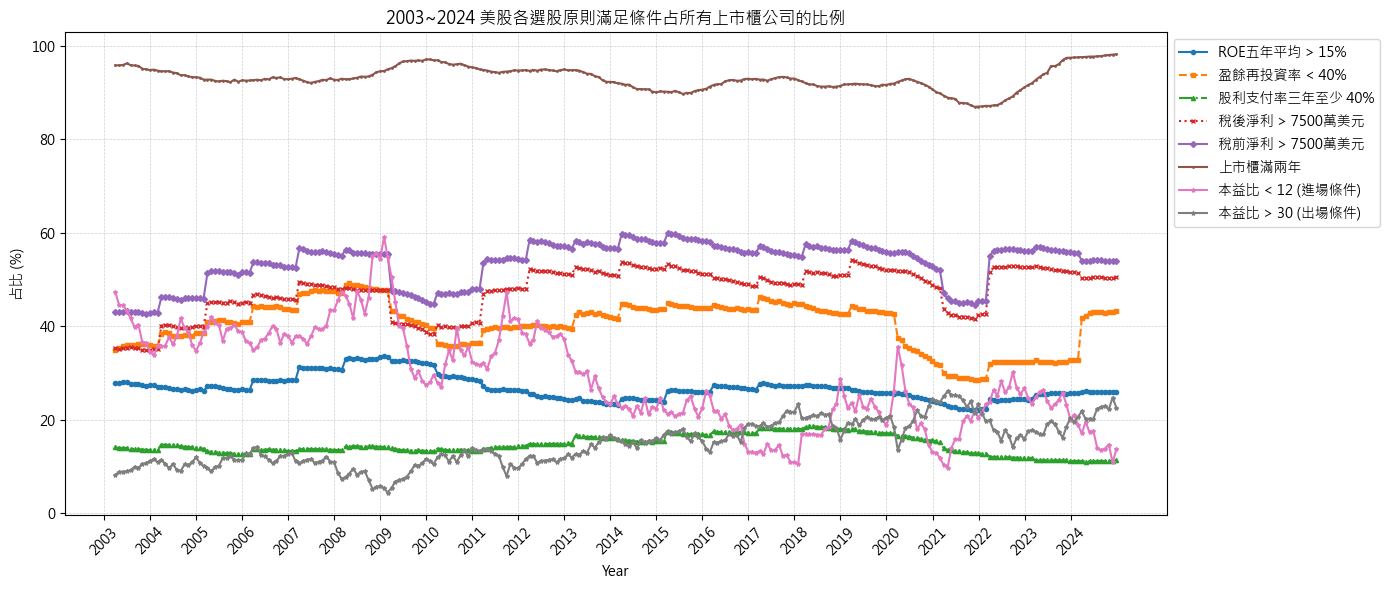

In [19]:
plt.figure(figsize=(14, 6))

roe_data = (roe_cond[START_DATE:END_DATE].sum(axis=1) / listed_df_count[START_DATE:END_DATE].sum(axis=1).resample('ME').last()) * 100
rr_data = (rr_cond[START_DATE:END_DATE].sum(axis=1) / listed_df_count[START_DATE:END_DATE].sum(axis=1).resample('ME').last()) * 100
payout_data = (payout_cond[START_DATE:END_DATE].sum(axis=1) / listed_df_count[START_DATE:END_DATE].sum(axis=1).resample('ME').last()) * 100
profit_data = (netprofit_cond[START_DATE:END_DATE].sum(axis=1) / listed_df_count[START_DATE:END_DATE].sum(axis=1).resample('ME').last()) * 100
bf_tax_data = (income_bf_tax_cond[START_DATE:END_DATE].sum(axis=1) / listed_df_count[START_DATE:END_DATE].sum(axis=1).resample('ME').last()) * 100
listed_data = (listed_cond[START_DATE:END_DATE].sum(axis=1) / listed_df_count[START_DATE:END_DATE].sum(axis=1).resample('ME').last()) * 100
pe_cond_entry_data = (daily_pe_entry[START_DATE:END_DATE].sum(axis=1) / listed_df_count[START_DATE:END_DATE].sum(axis=1).resample('ME').last()) * 100
pe_cond_exit_data = (daily_pe_exit[START_DATE:END_DATE].sum(axis=1) / listed_df_count[START_DATE:END_DATE].sum(axis=1).resample('ME').last()) * 100

# 繪製折線圖
plt.plot(roe_data.index, roe_data, marker='o', linestyle='-', markersize=3, label='ROE五年平均 > 15%')
plt.plot(rr_data.index, rr_data, marker='s', linestyle='--', markersize=3, label='盈餘再投資率 < 40%')
plt.plot(payout_data.index, payout_data, marker='^', linestyle='-.', markersize=3, label='股利支付率三年至少 40%')
plt.plot(profit_data.index, profit_data, marker='x', linestyle=':', markersize=3, label='稅後淨利 > 7500萬美元')
plt.plot(bf_tax_data.index, bf_tax_data, marker='D', linestyle='-', markersize=3, label='稅前淨利 > 7500萬美元')
plt.plot(listed_data.index, listed_data, marker='o', linestyle='-', markersize=1, label='上市櫃滿兩年')
plt.plot(pe_cond_entry_data.index, pe_cond_entry_data, marker='*', linestyle='-', markersize=3, label='本益比 < 12 (進場條件)')
plt.plot(pe_cond_exit_data.index, pe_cond_exit_data, marker='*', linestyle='-', markersize=3, label='本益比 > 30 (出場條件)')

# 設置 X 軸為每年年份
plt.xlabel("Year")
plt.ylabel("占比 (%)")
plt.title("2003~2024 美股各選股原則滿足條件占所有上市櫃公司的比例")
plt.grid(True)
plt.xticks(
    ticks=pd.date_range(start="2003-01-01", end="2024-12-31", freq="YS"),
    labels=pd.date_range(start="2003-01-01", end="2024-12-31", freq="YS").strftime("%Y"),
    rotation=45
)


plt.grid(linestyle='--', linewidth=0.5, alpha=0.6)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # 將圖例移動到圖表右上角外
plt.tight_layout()
plt.show()

---

## 羅素1000清單

In [20]:
russell_1000_df = pd.read_csv('./russell_component_lists/russell_1000_company.csv')
russell_1000_symbol = russell_1000_df['Symbol'].to_list()
filtered_russell_1000_symbol = [symbol for symbol in russell_1000_symbol if symbol in close.columns]

## 回測

In [21]:
# 無本益比進出場 #
# 稅後淨利條件
orig_all_cond = (roe_cond & rr_cond & payout_cond & netprofit_cond & listed_cond)[START_DATE:END_DATE]
# 稅前淨利條件
orig_all_cond_inc_bf_tax = (roe_cond & rr_cond & payout_cond & income_bf_tax_cond & listed_cond)[START_DATE:END_DATE]

# 有本益比進出場 #
# 每季本益比 #
# 稅後淨利條件
orig_all_cond_and_pe = ((orig_all_cond & pe_cond_entry[START_DATE:END_DATE]).hold_until((~orig_all_cond) | pe_cond_exit[START_DATE:END_DATE]))
# 稅前淨利條件
orig_all_cond_and_pe_inc_bf_tax = ((orig_all_cond_inc_bf_tax & pe_cond_entry[START_DATE:END_DATE]).hold_until((~orig_all_cond_inc_bf_tax) | pe_cond_exit[START_DATE:END_DATE]))

# 每月月底本益比 #
# 稅後淨利條件
orig_all_cond_and_pe_daily = ((orig_all_cond & daily_pe_entry[START_DATE:END_DATE]).hold_until((~orig_all_cond) | daily_pe_exit[START_DATE:END_DATE]))
# 稅前淨利條件
orig_all_cond_and_pe_daily_inc_bf_tax = ((orig_all_cond_inc_bf_tax & daily_pe_entry[START_DATE:END_DATE]).hold_until((~orig_all_cond_inc_bf_tax) | daily_pe_exit[START_DATE:END_DATE]))

In [22]:
rep_all_cond_dic = {}

rep_all_cond_dic['美股_原始條件_稅後淨利_不含本益比進出場'] = orig_all_cond
rep_all_cond_dic['美股_原始條件_稅前淨利_不含本益比進出場'] = orig_all_cond_inc_bf_tax

# rep_all_cond_dic['美股_原始條件_稅後淨利_每季本益比進出場'] = orig_all_cond_and_pe
# rep_all_cond_dic['美股_原始條件_稅前淨利_每季本益比進出場'] = orig_all_cond_and_pe_inc_bf_tax

rep_all_cond_dic['美股_原始條件_稅後淨利_每月月底本益比進出場'] = orig_all_cond_and_pe_daily
rep_all_cond_dic['美股_原始條件_稅前淨利_每月月底本益比進出場'] = orig_all_cond_and_pe_daily_inc_bf_tax

In [23]:
rep_all_cond = sim_conditions(rep_all_cond_dic, resample='ME', data=data)

Backtesting progress: 100%|██████████| 4/4 [00:09<00:00,  2.40s/condition]


In [24]:
# rep_all_cond.plot_creturns()

In [25]:
# rep_all_cond.plot_stats()

In [26]:
rep_all_cond.selected_stock_count_analysis()

CAGR (%)  MDD (%)  入選股數平均   中位數    25%    75%   Min  \
Strategy                                                                       
美股_原始條件_稅前淨利_不含本益比進出場       11.04   -50.79   43.19  39.0  27.25  63.00  13.0   
美股_原始條件_稅前淨利_每月月底本益比進出場     11.01   -51.16   22.81  24.0  18.00  28.00  10.0   
美股_原始條件_稅後淨利_每月月底本益比進出場     10.78   -53.11   22.28  24.0  18.00  26.75  11.0   
美股_原始條件_稅後淨利_不含本益比進出場       10.75   -52.54   41.71  37.0  28.00  58.00  14.0   

                          Max  
Strategy                       
美股_原始條件_稅前淨利_不含本益比進出場    76.0  
美股_原始條件_稅前淨利_每月月底本益比進出場  37.0  
美股_原始條件_稅後淨利_每月月底本益比進出場  38.0  
美股_原始條件_稅後淨利_不含本益比進出場    75.0

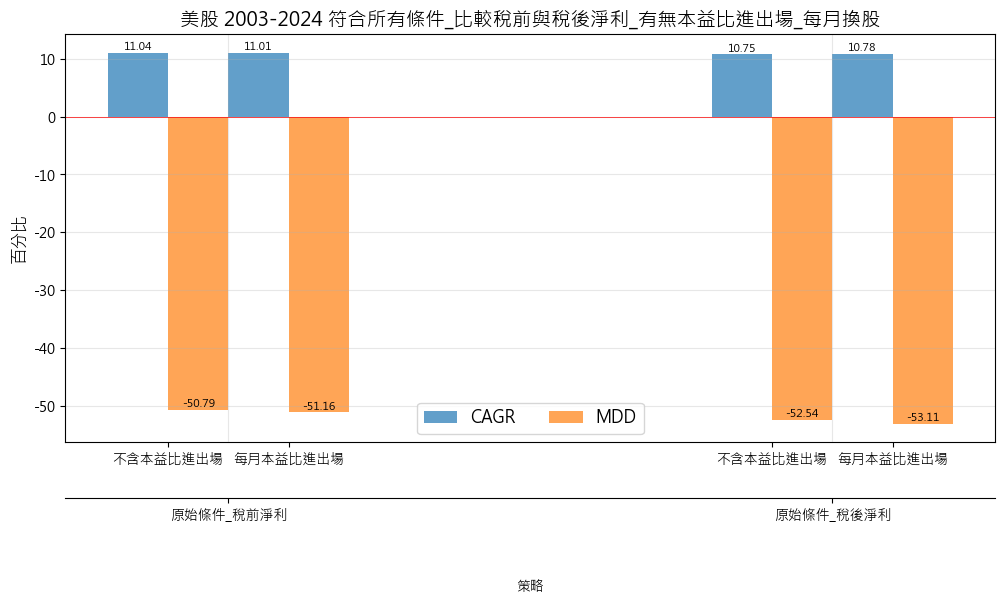

In [59]:
rep_all_cond_df = rep_all_cond.selected_stock_count_analysis()
rep_all_cond_df = rep_all_cond_df.reset_index()

# 分組資料
no_pe = rep_all_cond_df[rep_all_cond_df['Strategy'].str.contains('不含本益比進出場')]
monthly_pe = rep_all_cond_df[rep_all_cond_df['Strategy'].str.contains('月底本益比進出場')]

# 提取x軸標籤
no_pe_labels = [s.split('_')[1:3] for s in no_pe['Strategy']]
no_pe_labels = ['_'.join(label) for label in no_pe_labels]

# 設置圖表
plt.figure(figsize=(12, 6))
width = 0.1

# 設置x軸位置
x = range(len(no_pe_labels))

# 繪製bars
bars1 = plt.bar([i - width*1.5 for i in x], no_pe['CAGR (%)'], width, label='CAGR', color='tab:blue', alpha=0.7)
bars2 = plt.bar([i - width/2 for i in x], no_pe['MDD (%)'], width, label='MDD', color='tab:orange', alpha=0.7)
bars3 = plt.bar([i + width/2 for i in x], monthly_pe['CAGR (%)'], width, label='', color='tab:blue', alpha=0.7)
bars4 = plt.bar([i + width*1.5 for i in x], monthly_pe['MDD (%)'], width, label='', color='tab:orange', alpha=0.7)

# 添加數值標籤
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', fontsize=8)

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', fontsize=8)

for bar in bars3:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', fontsize=8)

for bar in bars4:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', fontsize=8)

# 獲取軸對象
ax = plt.gca()

# 設置Y軸刻度，以10為間隔
ax.yaxis.set_major_locator(plt.MultipleLocator(10))

# 設置網格線
plt.grid(True, alpha=0.3, which='both', axis='both')

# 設置主要x軸標籤（策略名稱）
ax.set_xticks([i for i in x])
ax.set_xticklabels(no_pe_labels, rotation=0)

# 添加次要x軸標籤（本益比條件）
ax2 = ax.secondary_xaxis('bottom') 
# 調整標籤位置，使其對齊對應的柱狀圖組
ax2.set_xticks([i - width for i in x] + [i + width for i in x])
ax2.set_xticklabels(['不含本益比進出場']*len(no_pe_labels) + ['每月本益比進出場']*len(no_pe_labels), fontsize=10)

# 移動主要x軸到次要x軸的下方
ax.xaxis.set_label_position('bottom')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('outward', 40))

# 設置圖表外觀
ax.set_xlabel('策略', labelpad=40)  # 增加labelpad使標籤遠離軸
ax.tick_params(axis='y', labelsize=10)

plt.ylabel('百分比', fontsize=12)
plt.title('美股 2003-2024 符合所有條件_比較稅前與稅後淨利_有無本益比進出場_每月換股', fontsize=14)
plt.legend(loc='lower center', ncol=2, fontsize=12)
plt.axhline(0, color='red', linewidth=0.5)

# 調整版面配置
plt.subplots_adjust(bottom=0.2)  # 增加底部空間以容納標籤

# 顯示圖表
plt.show()

In [28]:
# rep_all_cond.selected_stock_count_analysis(ratio=True)

In [29]:
rep_all_cond.holding_period_analysis()

CAGR (%)  MDD (%)       持有期間平均    25%    中位數     75%  \
Strategy                                                                        
美股_原始條件_稅前淨利_不含本益比進出場       11.04   -50.79  1118.937908  365.0  728.5  1460.5   
美股_原始條件_稅前淨利_每月月底本益比進出場     11.01   -51.16   944.911458  336.0  455.5  1105.0   
美股_原始條件_稅後淨利_每月月底本益比進出場     10.78   -53.11   923.067708  336.0  412.0  1066.0   
美股_原始條件_稅後淨利_不含本益比進出場       10.75   -52.54  1106.147157  365.0  701.0  1444.5   

                            最大值   最小值  
Strategy                               
美股_原始條件_稅前淨利_不含本益比進出場    7945.0  31.0  
美股_原始條件_稅前淨利_每月月底本益比進出場  5935.0  31.0  
美股_原始條件_稅後淨利_每月月底本益比進出場  5935.0  31.0  
美股_原始條件_稅後淨利_不含本益比進出場    7945.0  31.0

---

In [30]:
# rep_all_cond.reports['美股_原始條件_稅後淨利_不含本益比進出場'].display()

In [31]:
orig_strat_pos, orig_strat_neg = rep_all_cond.reports['美股_原始條件_稅後淨利_不含本益比進出場'].calc_returns_contrib(5)

In [32]:
orig_daily_pe_strat_pos, orig_daily_pe_strat_neg = rep_all_cond.reports['美股_原始條件_稅後淨利_每月月底本益比進出場'].calc_returns_contrib(5)

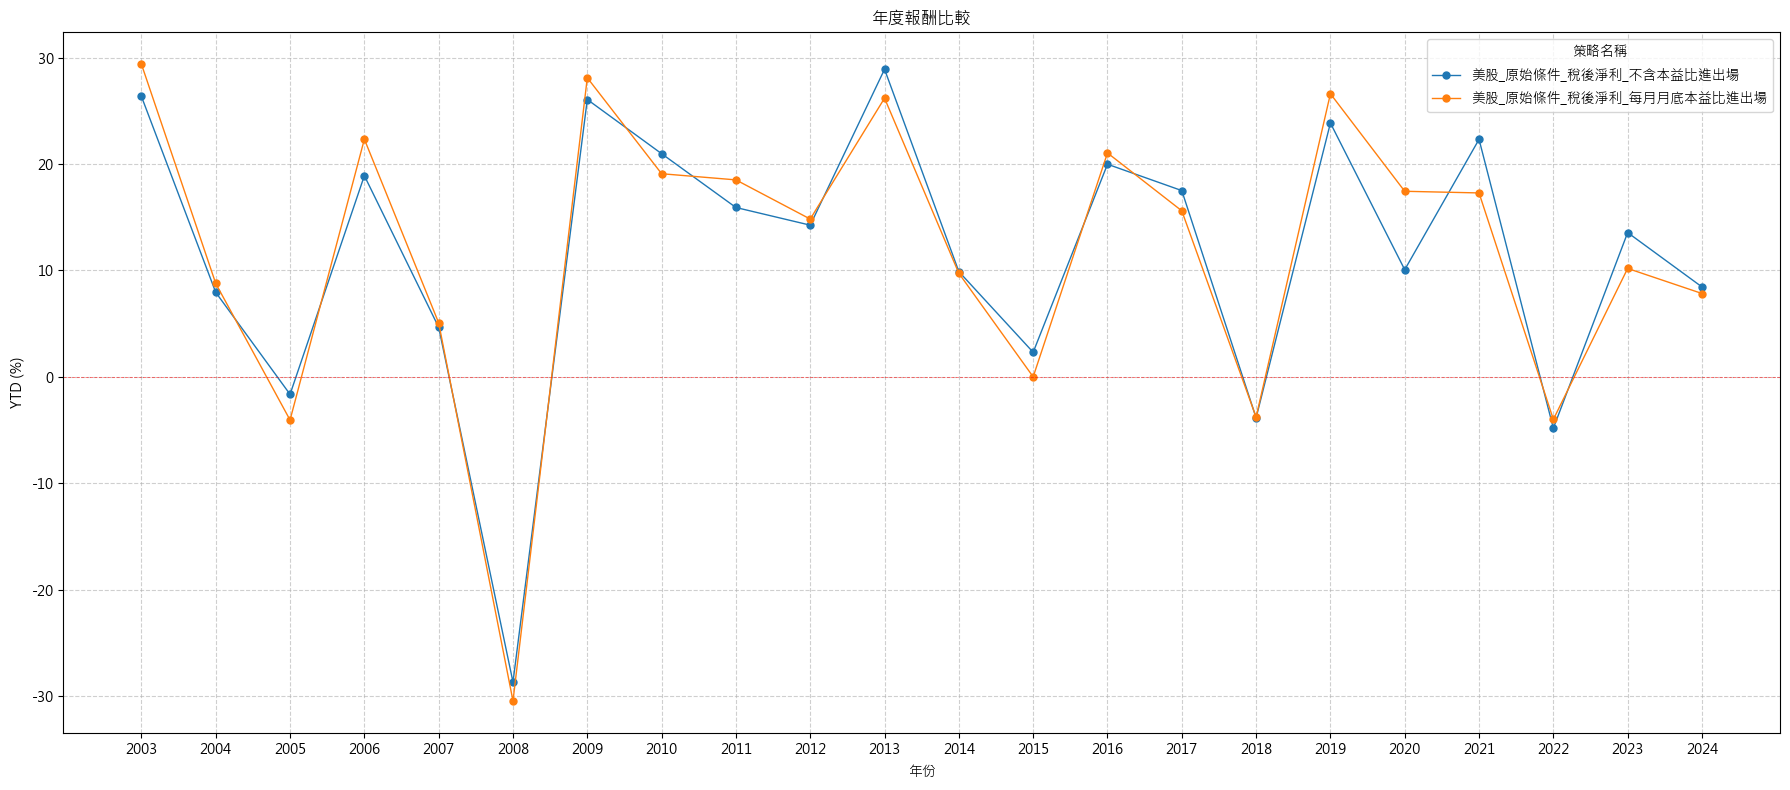

In [33]:
rep_all_cond.visualize_ytd_performance(['美股_原始條件_稅後淨利_不含本益比進出場', '美股_原始條件_稅後淨利_每月月底本益比進出場'])

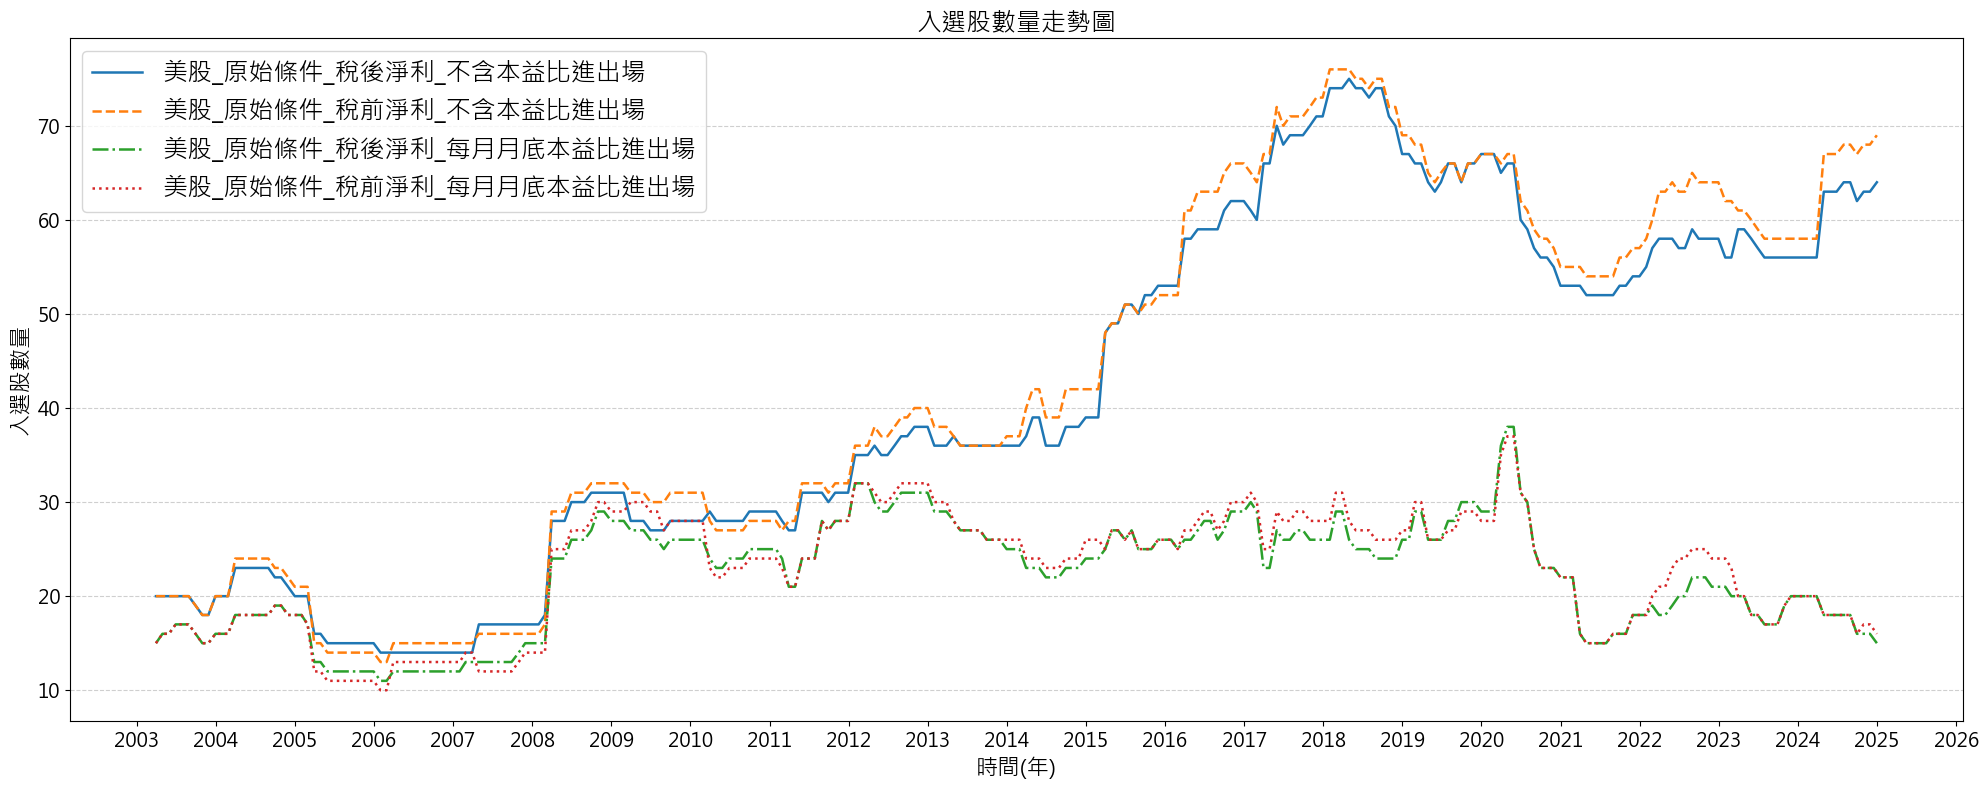

In [34]:
rep_all_cond.plot_reps_stock_counts()

## 切分時間段2003~2009、2009~2024

In [35]:
orig_all_cond_2003_2009 = (roe_cond & rr_cond & payout_cond & netprofit_cond & listed_cond)[START_DATE:'2009-3-31']
orig_all_cond_bftax_2003_2009 = (roe_cond & rr_cond & payout_cond & income_bf_tax_cond & listed_cond)[START_DATE:'2009-3-31']

orig_all_cond_2009_2024 = (roe_cond & rr_cond & payout_cond & netprofit_cond & listed_cond)['2009-3-31':END_DATE]
orig_all_cond_bftax_2009_2024 = (roe_cond & rr_cond & payout_cond & income_bf_tax_cond & listed_cond)['2009-3-31':END_DATE]

# all_cond_and_pe_2003_2009 = ((orig_all_cond_2003_2009 & pe_cond_entry[START_DATE:'2009-3-31']).hold_until((~orig_all_cond_2003_2009) | pe_cond_exit[START_DATE:'2009-3-31']))
# all_cond_and_pe_bftax_2003_2009 = ((orig_all_cond_bftax_2003_2009 & pe_cond_entry[START_DATE:'2009-3-31']).hold_until((~orig_all_cond_bftax_2003_2009) | pe_cond_exit[START_DATE:'2009-3-31']))

# all_cond_and_pe_2009_2024 = ((orig_all_cond_2009_2024 & pe_cond_entry['2009-3-31':END_DATE]).hold_until((~orig_all_cond_2009_2024) | pe_cond_exit['2009-3-31':END_DATE]))
# all_cond_and_pe_bftax_2009_2024 = ((orig_all_cond_bftax_2009_2024 & pe_cond_entry['2009-3-31':END_DATE]).hold_until((~orig_all_cond_bftax_2009_2024) | pe_cond_exit['2009-3-31':END_DATE]))

all_cond_and_pe_daily_2003_2009 = ((orig_all_cond_2003_2009 & daily_pe_entry[START_DATE:'2009-3-31']).hold_until((~orig_all_cond_2003_2009) | daily_pe_exit[START_DATE:'2009-3-31']))
all_cond_and_pe_daily_bftax_2003_2009 = ((orig_all_cond_bftax_2003_2009 & daily_pe_entry[START_DATE:'2009-3-31']).hold_until((~orig_all_cond_bftax_2003_2009) | daily_pe_exit[START_DATE:'2009-3-31']))

all_cond_and_pe_daily_2009_2024 = ((orig_all_cond_2009_2024 & daily_pe_entry['2009-3-31':END_DATE]).hold_until((~orig_all_cond_2009_2024) | daily_pe_exit['2009-3-31':END_DATE]))
all_cond_and_pe_daily_bftax_2009_2024 = ((orig_all_cond_bftax_2009_2024 & daily_pe_entry['2009-3-31':END_DATE]).hold_until((~orig_all_cond_bftax_2009_2024) | daily_pe_exit['2009-3-31':END_DATE]))

In [36]:
time_period_dic = {}

time_period_dic['美股_稅後淨利_不含本益比進出場_2003-2009'] = orig_all_cond_2003_2009
time_period_dic['美股_稅前淨利_不含本益比進出場_2003-2009'] = orig_all_cond_bftax_2003_2009
time_period_dic['美股_稅後淨利_不含本益比進出場_2009-2024'] = orig_all_cond_2009_2024
time_period_dic['美股_稅前淨利_不含本益比進出場_2009-2024'] = orig_all_cond_bftax_2009_2024

# time_period_dic['美股_稅後淨利_每季本益比進出場_2003-2009'] = all_cond_and_pe_2003_2009
# time_period_dic['美股_稅前淨利_每季本益比進出場_2003-2009'] = all_cond_and_pe_bftax_2003_2009
# time_period_dic['美股_稅後淨利_每季本益比進出場_2009-2024'] = all_cond_and_pe_2009_2024
# time_period_dic['美股_稅前淨利_每季本益比進出場_2009-2024'] = all_cond_and_pe_bftax_2009_2024

time_period_dic['美股_稅後淨利_每月月底本益比進出場_2003-2009'] = all_cond_and_pe_daily_2003_2009
time_period_dic['美股_稅前淨利_每月月底本益比進出場_2003-2009'] = all_cond_and_pe_daily_bftax_2003_2009
time_period_dic['美股_稅後淨利_每月月底本益比進出場_2009-2024'] = all_cond_and_pe_daily_2009_2024
time_period_dic['美股_稅前淨利_每月月底本益比進出場_2009-2024'] = all_cond_and_pe_daily_bftax_2009_2024

time_period_rep_collec = sim_conditions(time_period_dic, resample='ME', data=data)

Backtesting progress: 100%|██████████| 8/8 [00:14<00:00,  1.83s/condition]


In [37]:
time_period_rep_collec.selected_stock_count_analysis()

CAGR (%)  MDD (%)  入選股數平均   中位數   25%   75%  \
Strategy                                                                    
美股_稅前淨利_不含本益比進出場_2009-2024       14.97   -38.26   52.08  56.5  37.0  65.0   
美股_稅後淨利_不含本益比進出場_2009-2024       14.75   -38.83   50.11  53.5  36.0  62.0   
美股_稅前淨利_每月月底本益比進出場_2009-2024     14.68   -39.46   25.21  26.0  23.0  28.0   
美股_稅後淨利_每月月底本益比進出場_2009-2024     14.57   -39.38   24.48  25.0  22.0  27.0   
美股_稅前淨利_每月月底本益比進出場_2003-2009      1.36   -51.16   16.63  15.0  13.0  18.0   
美股_稅前淨利_不含本益比進出場_2003-2009        1.00   -50.79   19.90  18.0  15.0  24.0   
美股_稅後淨利_每月月底本益比進出場_2003-2009      0.82   -53.11   16.56  15.0  12.0  18.0   
美股_稅後淨利_不含本益比進出場_2003-2009        0.53   -52.54   19.67  18.0  15.0  23.0   

                               Min   Max  
Strategy                                  
美股_稅前淨利_不含本益比進出場_2009-2024    27.0  76.0  
美股_稅後淨利_不含本益比進出場_2009-2024    27.0  75.0  
美股_稅前淨利_每月月底本益比進出場_2009-2024  15.0  37.0  
美股_稅後淨利_每月月底本益比進出場_2009-2024  15.0  38.0  
美股_稅前淨利_每月月底本益比進出場_2003-2009  10.0  30.0  
美股_稅前淨利_不含本益比進出場_2003-2009    13.0  32.0  
美股_稅後淨利_每月月底本益比進出場_2003-2009  11.0  29.0  
美股_稅後淨利_不含本益比進出場_2003-2009    14.0  31.0

In [38]:
def plot_grouped_bar_chart(df):
    # 重置索引
    df.reset_index(inplace=True)
    
    # 解析 Strategy column
    df[['條件', '策略', '時間段']] = df['Strategy'].str.split('_', expand=True).iloc[:, 1:]

    # 排除非數值列
    numeric_columns = df.select_dtypes(include='number').columns
    grouped = df.groupby(['條件', '策略', '時間段'])[numeric_columns].mean().reset_index()

    # 獲取 unique 的條件和策略
    conditions = grouped['條件'].unique()
    strategies = grouped['策略'].unique()

    # 設置 bar 的寬度和位置
    bar_width = 0.2
    index = range(len(conditions) * len(strategies))

    # 創建子圖
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))

    # 繪製 CAGR (%) 的 grouped bar chart
    for i, time_period in enumerate(['2003-2009', '2009-2024']):
        data = grouped[grouped['時間段'] == time_period]
        cagr_values = data['CAGR (%)'].values
        bar_positions = [x + i * bar_width for x in index]
        ax1.bar(bar_positions, cagr_values, bar_width, label=f'{time_period}')

    # 設置 x 軸標籤
    ax1.set_xticks([x + bar_width / 2 for x in index])
    ax1.set_xticklabels([f'{cond}_{strat}' for cond in conditions for strat in strategies], rotation=0, ha='center', fontsize=14)
    ax1.grid(True, alpha=0.3)

    # 添加標籤和標題
    ax1.set_xlabel('Strategy')
    ax1.set_ylabel('CAGR (%)', fontsize=14)
    ax1.yaxis.set_major_locator(FixedLocator(ax1.get_yticks()))
    ax1.yaxis.set_major_formatter(FixedFormatter([f'{int(x)}' for x in ax1.get_yticks()]))
    ax1.set_title('美股 2009-2009、2009-2024 不同時間段 CAGR 比較', fontsize=18)
    ax1.tick_params(axis='y', labelsize=16)  # 設置Y軸刻度字體大小

    # 繪製 MDD (%) 的 grouped bar chart
    for i, time_period in enumerate(['2003-2009', '2009-2024']):
        data = grouped[grouped['時間段'] == time_period]
        mdd_values = data['MDD (%)'].values
        bar_positions = [x + i * bar_width for x in index]
        ax2.bar(bar_positions, mdd_values, bar_width, label=f'{time_period}')

    # 設置 x 軸標籤
    ax2.set_xticks([x + bar_width / 2 for x in index])
    ax2.set_xticklabels([f'{cond}_{strat}' for cond in conditions for strat in strategies], rotation=0, ha='center', fontsize=14)

    # 添加標籤和標題
    ax2.set_xlabel('Strategy')
    ax2.set_ylabel('MDD (%)', fontsize=14)
    ax2.yaxis.set_major_locator(FixedLocator(ax2.get_yticks()))
    ax2.yaxis.set_major_formatter(FixedFormatter([f'{int(x)}' for x in ax2.get_yticks()]))
    ax2.set_title('美股 2009-2009、2009-2024 不同時間段 MDD 比較', fontsize=18)
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='y', labelsize=16)  # 設置Y軸刻度字體大小

    # 添加統一的 legend
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=2, fontsize=18)

    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.show()

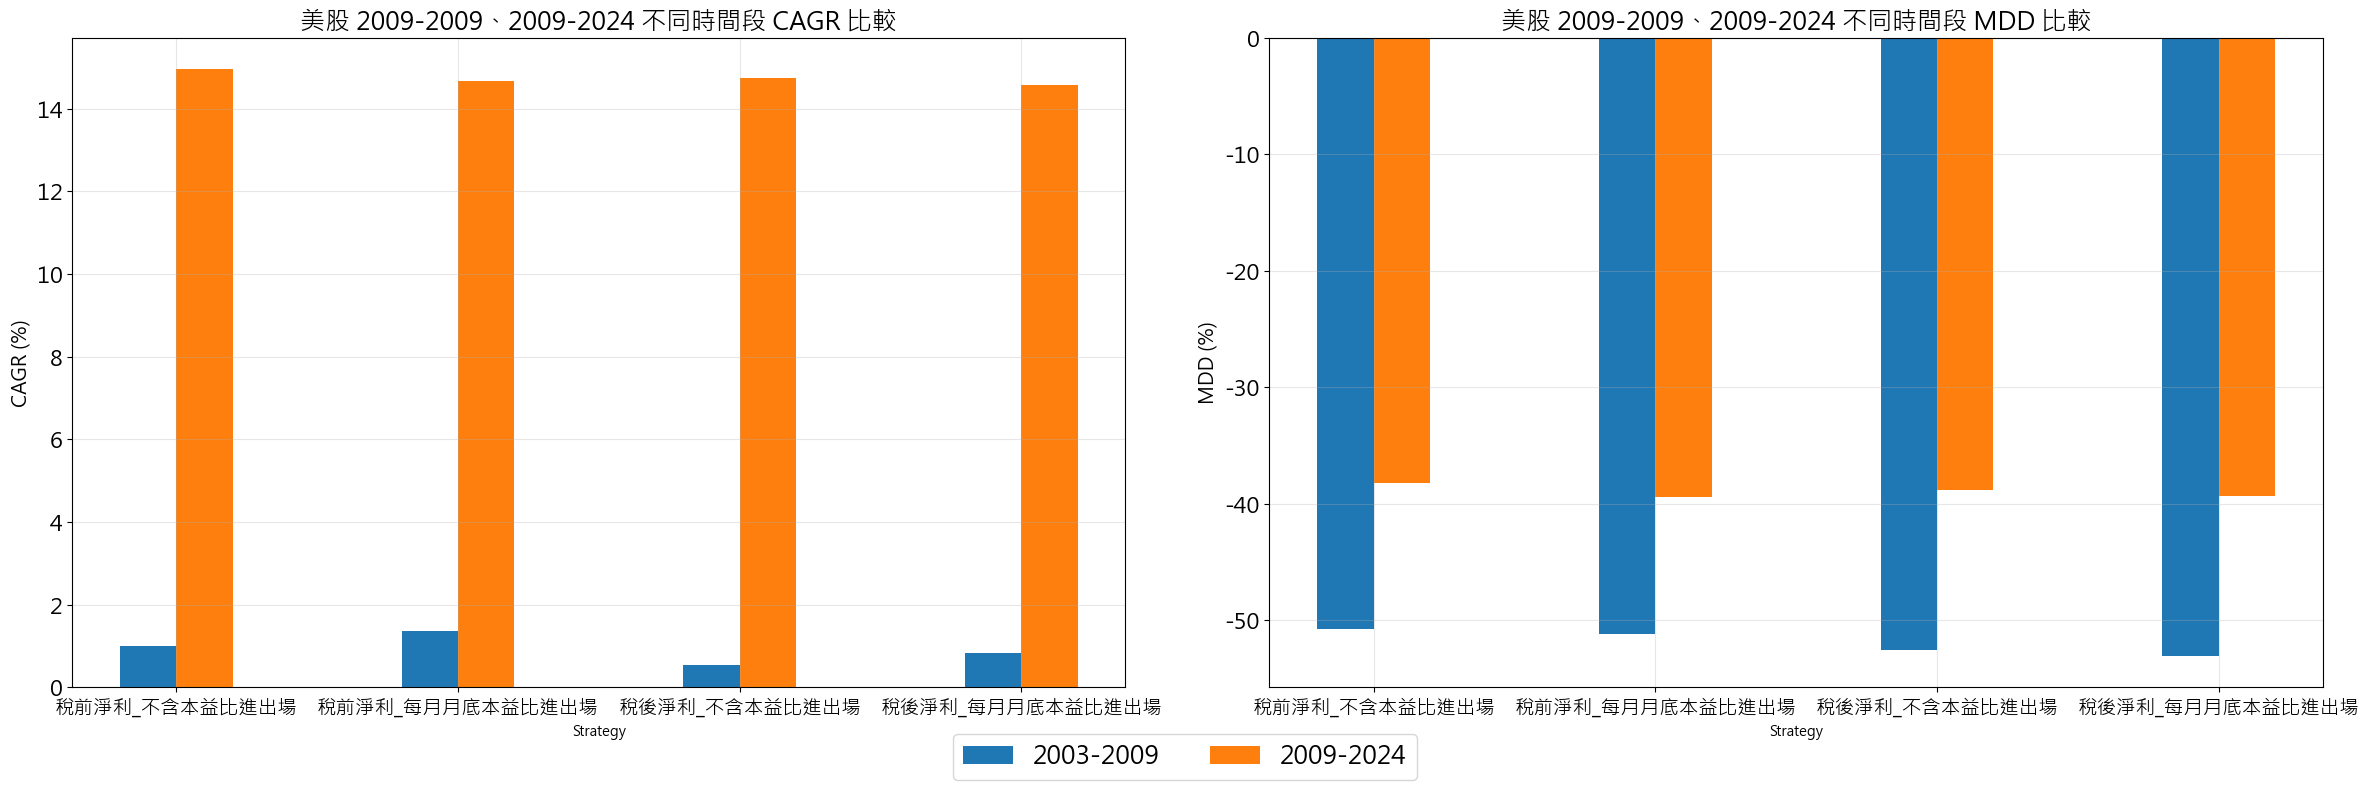

In [39]:
time_period_test_df = time_period_rep_collec.selected_stock_count_analysis()
plot_grouped_bar_chart(time_period_test_df)

In [40]:
us_bench = data.get('ruaindex:close')[START_DATE:END_DATE]
us_bench['close'] = us_bench['close'] / us_bench['close'].iloc[0]

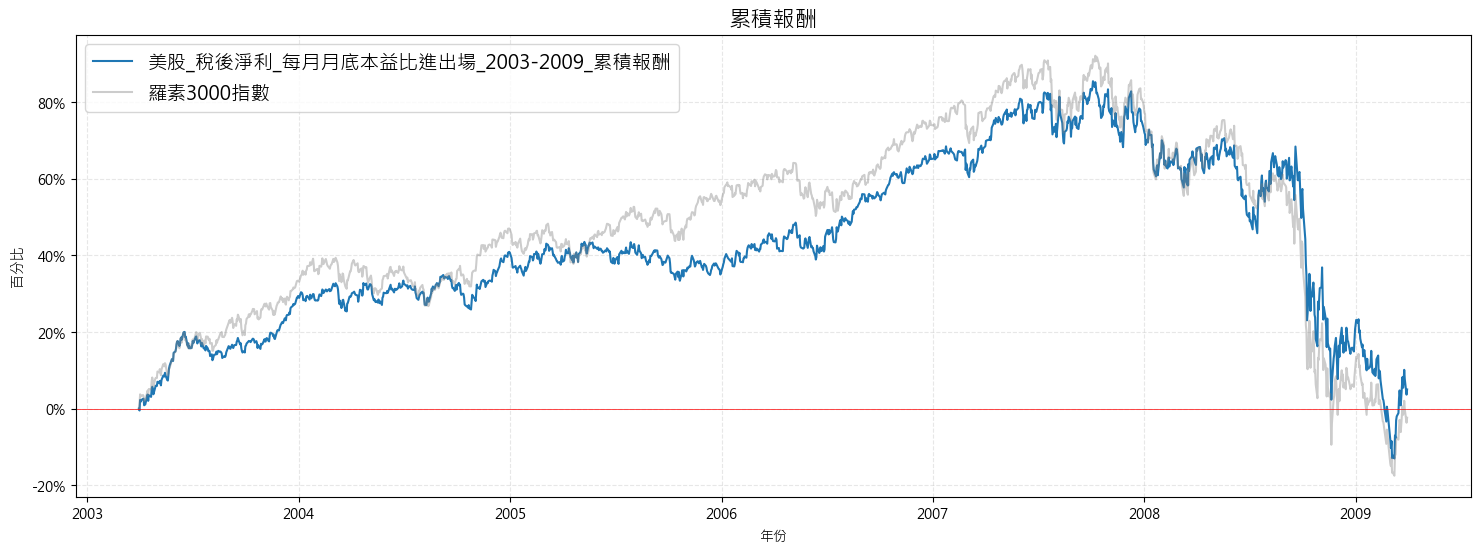

In [61]:
cum_returns = time_period_rep_collec.reports['美股_稅後淨利_每月月底本益比進出場_2003-2009'].stock_data['cum_returns']
us_close = us_bench['close'].reindex(cum_returns.index)

plt.figure(figsize=(18, 6))

# Plot cumulative returns
plt.plot(cum_returns.index, cum_returns, label='美股_稅後淨利_每月月底本益比進出場_2003-2009_累積報酬')

# Plot normalized close prices
plt.plot(us_close.index, us_close, label='羅素3000指數', color='gray', alpha=0.4)

plt.xlabel('年份')
plt.ylabel('百分比')
plt.axhline(1, color='red', linewidth=0.5)
plt.title('累積報酬', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True, alpha=0.3, linestyle='--')

# Custom y-ticks formatter
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{(x - 1) * 100:.0f}%'))

plt.show()


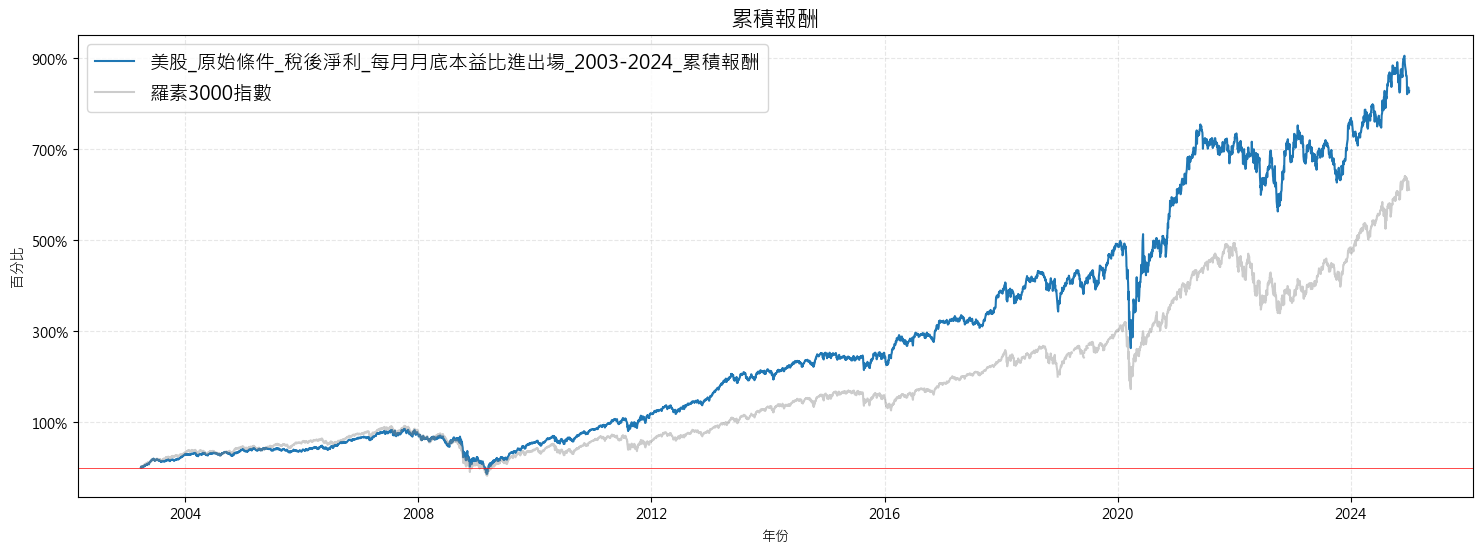

In [62]:
cum_returns = rep_all_cond.reports['美股_原始條件_稅後淨利_每月月底本益比進出場'].stock_data['cum_returns']
us_close = us_bench['close'].reindex(cum_returns.index)

plt.figure(figsize=(18, 6))

# Plot cumulative returns
plt.plot(cum_returns.index, cum_returns, label='美股_原始條件_稅後淨利_每月月底本益比進出場_2003-2024_累積報酬')

# Plot normalized close prices
plt.plot(us_close.index, us_close, label='羅素3000指數', color='gray', alpha=0.4)

plt.xlabel('年份')
plt.ylabel('百分比')
plt.axhline(1, color='red', linewidth=0.5)
plt.title('累積報酬', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True, alpha=0.3, linestyle='--')

# Custom y-ticks formatter
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{(x - 1) * 100:.0f}%'))

plt.show()


## 美股_布林通道濾網

In [43]:
us_benchmark = data.get('ruaindex:close')['2002':'2024']
upperband, middleband, lowerband = talib.BBANDS(us_benchmark.close, timeperiod=300, nbdevup=2.0, nbdevdn=2.0)

### 建立濾網
1. 第一次跌破下通道先記錄下來，等到下一次跌破而且到更低的收盤價賣出
2. 等回到均線之上再買入

In [44]:
# 創建一個買賣訊號的DataFrame，初始值全部為True
us_bollinger_signal = pd.Series(True, index=us_benchmark.index)

# 記錄第一次跌破的價格
first_break_price = None
# 記錄是否已經回到lower band之上
crossed_above_lower = False
# 是否進入持續的 False 狀態直到突破中通道
in_selling_state = False

# 遍歷所有的日期
for date in us_benchmark.index:
    price = us_benchmark.close[date]
    lower = lowerband[date]
    middle = middleband[date]
    
    # 第一次跌破下通道
    if price < lower and first_break_price is None:
        first_break_price = price
        crossed_above_lower = False
    
    # 價格回到下通道之上
    elif price > lower:
        crossed_above_lower = True
    
    # 再次跌破下通道且符合賣出條件
    if price < lower and crossed_above_lower and price < first_break_price:

        # print(f'{date} - {price} - {lower} - {first_break_price}')
        
        us_bollinger_signal[date] = False
        in_selling_state = True
    
    # 突破中通道則重置狀態
    if price > middle:
        us_bollinger_signal[date] = True
        first_break_price = None
        crossed_above_lower = False
        in_selling_state = False
    
    # 在突破中通道之前保持賣出狀態
    if in_selling_state and price <= middle:
        us_bollinger_signal[date] = False

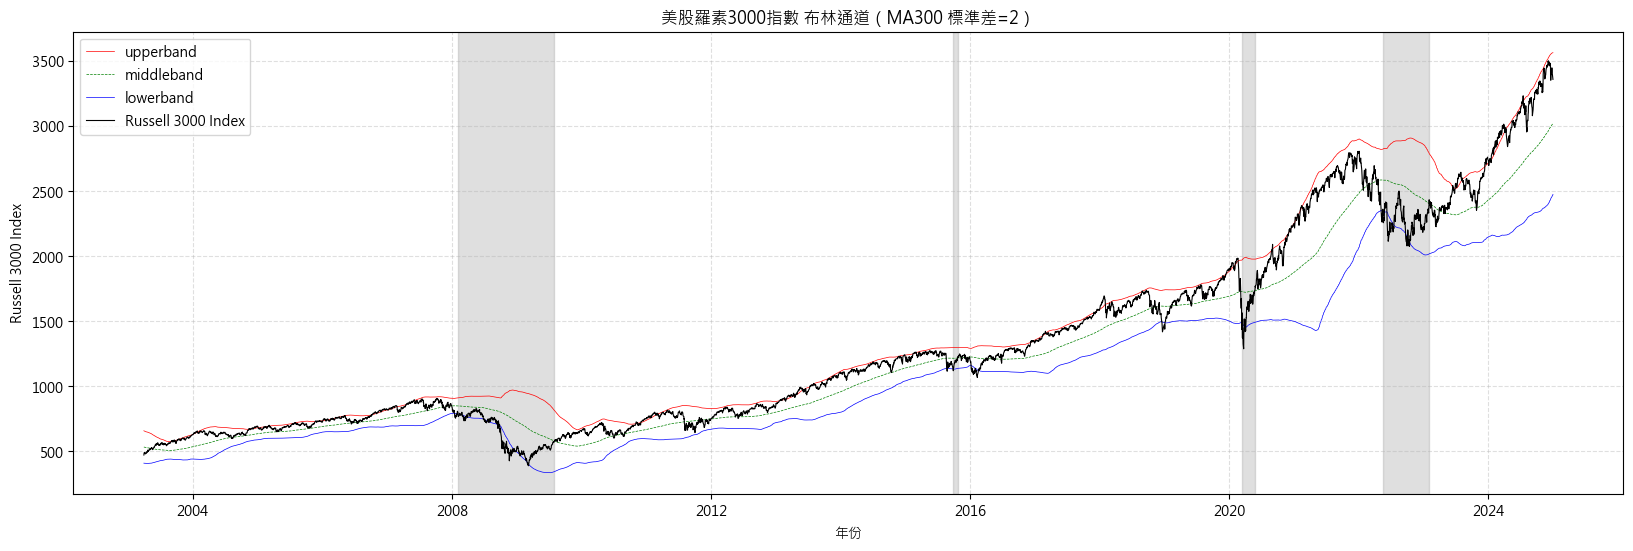

In [45]:
plt.figure(figsize=(20, 6))

plt.plot(upperband['2003-3-31':'2024'],
         label="upperband",color='r',
         linestyle='solid', linewidth=0.5)
plt.plot(middleband['2003-3-31':'2024'],
         label="middleband",color='g',linestyle='--', linewidth=0.5)
plt.plot(lowerband['2003-3-31':'2024'],
         label="lowerband",color='b',
         linestyle='solid', linewidth=0.5)
plt.plot(us_benchmark['2003-3-31':'2024'],
         label="Russell 3000 Index",color='black', linewidth=0.8)

plt.title("美股羅素3000指數 布林通道（MA300 標準差=2）") 
plt.xlabel("年份") 
plt.ylabel("Russell 3000 Index")

# 添加背景顏色
plt.axvspan(pd.Timestamp('2008-2-5'), pd.Timestamp('2009-7-31'), color='gray', alpha=0.25)
plt.axvspan(pd.Timestamp('2015-9-28'), pd.Timestamp('2015-10-23'), color='gray', alpha=0.25)
plt.axvspan(pd.Timestamp('2020-3-16'), pd.Timestamp('2020-5-26'), color='gray', alpha=0.25)
plt.axvspan(pd.Timestamp('2022-5-18'), pd.Timestamp('2023-2-2'), color='gray', alpha=0.25)

plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

In [46]:
bolling_filt = orig_all_cond.copy()

# 將 df 的 index 對齊 us_bollinger_signal_1 的 index，並填充為 True，這樣可以保證日期範圍內的所有日期都包括
aligned_signal = us_bollinger_signal.reindex(bolling_filt.index, method='ffill', fill_value=True)

# 將 df 中日期對應的行設置為 aligned_signal 的值
bolling_filt.loc[aligned_signal.index, :] = aligned_signal.values[:, None]

In [47]:
filtered_russell_1000_symbol = [symbol for symbol in filtered_russell_1000_symbol if symbol not in ['ALAB', 'LOAR']]

In [48]:
# bf_tax_cond = income_bf_tax > 75000000
orig_cond_bft = rr_cond & roe_cond & income_bf_tax_cond & payout_cond & listed_cond
nodpr_bft_cond = rr_cond & roe_cond & income_bf_tax_cond & listed_cond



overall_russell_filt_conds = {}

# overall_conds['所有條件_盈再率<80_無本益比'] = orig_cond
overall_russell_filt_conds['所有條件_無本益比'] = orig_all_cond[START_DATE:END_DATE]
# overall_conds['所有條件_無本益比_稅前淨利'] = orig_cond_bft[START_DATE:END_DATE]
overall_russell_filt_conds['所有條件_無本益比_羅素1000'] = orig_all_cond[filtered_russell_1000_symbol][START_DATE:END_DATE]
overall_russell_filt_conds['所有條件_無本益比_羅素1000_布林通道'] = (orig_all_cond[filtered_russell_1000_symbol] & bolling_filt)[START_DATE:END_DATE]
# overall_conds['所有條件_無本益比_稅前淨利_羅素1000'] = orig_cond_bft[START_DATE:END_DATE][filtered_russell_1000_symbol]
overall_russell_filt_conds['所有條件_無本益比_布林通道'] = (orig_all_cond & bolling_filt)[START_DATE:END_DATE]
overall_russell_filt_conds['所有條件_無本益比_ROE出場條件'] = (orig_all_cond & (roe[START_DATE:END_DATE] > 0.15))[START_DATE:END_DATE]
overall_russell_filt_conds['所有條件_無本益比_ROE出場條件_布林通道'] = (orig_all_cond[START_DATE:END_DATE] & bolling_filt[START_DATE:END_DATE] & (roe[START_DATE:END_DATE] > 0.15))[START_DATE:END_DATE]
overall_russell_filt_conds['所有條件_無本益比_ROE出場條件_羅素1000'] = (orig_all_cond & (roe[START_DATE:END_DATE] > 0.15))[filtered_russell_1000_symbol][START_DATE:END_DATE]
overall_russell_filt_conds['所有條件_無本益比_ROE出場條件_羅素1000_布林通道'] = (orig_all_cond & bolling_filt[START_DATE:END_DATE] & (roe[START_DATE:END_DATE] > 0.15))[filtered_russell_1000_symbol][START_DATE:END_DATE]

# overall_conds['所有條件_盈再率<80_每季本益比'] = orig_quarter_pe
overall_russell_filt_conds['所有條件_有本益比'] = orig_all_cond_and_pe_daily[START_DATE:END_DATE]
overall_russell_filt_conds['所有條件_有本益比_ROE出場條件'] = (orig_all_cond[START_DATE:END_DATE] & daily_pe_entry[START_DATE:END_DATE]).hold_until((~orig_all_cond[START_DATE:END_DATE]) | daily_pe_exit[START_DATE:END_DATE] | (roe[START_DATE:END_DATE] < 0.15))
overall_russell_filt_conds['所有條件_有本益比_布林通道'] = (orig_all_cond[START_DATE:END_DATE] & daily_pe_entry[START_DATE:END_DATE] & bolling_filt[START_DATE:END_DATE]).hold_until((~orig_all_cond[START_DATE:END_DATE]) | daily_pe_exit[START_DATE:END_DATE] | ~bolling_filt[START_DATE:END_DATE])
overall_russell_filt_conds['所有條件_有本益比_ROE出場條件_布林通道'] = (orig_all_cond[START_DATE:END_DATE] & daily_pe_entry[START_DATE:END_DATE] & bolling_filt[START_DATE:END_DATE]).hold_until((~orig_all_cond[START_DATE:END_DATE]) | daily_pe_exit[START_DATE:END_DATE] | (roe[START_DATE:END_DATE] < 0.15) | ~bolling_filt[START_DATE:END_DATE])
overall_russell_filt_conds['所有條件_有本益比_ROE出場條件_羅素1000_布林通道'] = (orig_all_cond[START_DATE:END_DATE] & daily_pe_entry[START_DATE:END_DATE] & bolling_filt[START_DATE:END_DATE]).hold_until((~orig_all_cond[START_DATE:END_DATE]) | daily_pe_exit[START_DATE:END_DATE] | (roe[START_DATE:END_DATE] < 0.15) | ~bolling_filt[START_DATE:END_DATE])[filtered_russell_1000_symbol]


# overall_conds['所有條件_有本益比_稅前淨利'] = (orig_cond_bft[START_DATE:END_DATE] & daily_pe_entry[START_DATE:END_DATE]).hold_until((~orig_cond_bft[START_DATE:END_DATE]) | daily_pe_exit[START_DATE:END_DATE])
overall_russell_filt_conds['所有條件_有本益比_羅素1000'] = orig_all_cond_and_pe_daily[filtered_russell_1000_symbol][START_DATE:END_DATE]
overall_russell_filt_conds['所有條件_有本益比_羅素1000_布林通道'] = (orig_all_cond[START_DATE:END_DATE] & daily_pe_entry[START_DATE:END_DATE] & bolling_filt[START_DATE:END_DATE]).hold_until((~orig_all_cond[START_DATE:END_DATE]) | daily_pe_exit[START_DATE:END_DATE] | ~bolling_filt[START_DATE:END_DATE])[filtered_russell_1000_symbol]
overall_russell_filt_conds['所有條件_有本益比_ROE出場條件_羅素1000'] = (orig_all_cond[START_DATE:END_DATE] & daily_pe_entry[START_DATE:END_DATE] & bolling_filt[START_DATE:END_DATE]).hold_until((~orig_all_cond[START_DATE:END_DATE]) | daily_pe_exit[START_DATE:END_DATE] | (roe[START_DATE:END_DATE] < 0.15))[filtered_russell_1000_symbol] 
# overall_conds['所有條件_有本益比_稅前淨利_羅素1000'] = (orig_cond_bft[START_DATE:END_DATE] & daily_pe_entry[START_DATE:END_DATE]).hold_until((~orig_cond_bft[START_DATE:END_DATE]) | daily_pe_exit[START_DATE:END_DATE])[filtered_russell_1000_symbol]

# # overall_conds['去掉配息盈再率<80_無本益比'] = test_cond
# overall_conds['去掉配息_無本益比'] = nodpr_cond_opt
# # overall_conds['去掉配息_無本益比_稅前淨利'] = nodpr_bft_cond[START_DATE:END_DATE]
# overall_conds['去掉配息_無本益比_羅素1000'] = nodpr_cond_opt_filter
# # overall_conds['去掉配息_無本益比_稅前淨利_羅素1000'] = nodpr_bft_cond[START_DATE:END_DATE][filtered_russell_1000_symbol]
# # overall_conds['去掉配息_盈再率<80_每季本益比'] = test_noDPR_pe
# overall_conds['去掉配息_無本益比_布林通道'] = nodpr_cond_opt & bolling_1_filt

# overall_conds['去掉配息_有本益比'] = opt_noDPR_pe
# overall_conds['去掉配息_有本益比_ROE出場條件'] = (nodpr_cond_opt & daily_pe_entry[START_DATE:END_DATE]).hold_until((~nodpr_cond_opt) | daily_pe_exit[START_DATE:END_DATE] | (roe[START_DATE:END_DATE] < 0.15))
# # overall_conds['去掉配息_有本益比_稅前淨利'] = (nodpr_bft_cond[START_DATE:END_DATE] & daily_pe_entry[START_DATE:END_DATE]).hold_until((~nodpr_bft_cond[START_DATE:END_DATE]) | daily_pe_exit[START_DATE:END_DATE])
# overall_conds['去掉配息_有本益比_布林通道'] = (nodpr_cond_opt & daily_pe_entry[START_DATE:END_DATE]).hold_until((~nodpr_cond_opt) | daily_pe_exit[START_DATE:END_DATE] | ~bolling_1_filt)
# overall_conds['去掉配息_有本益比_布林通道_ROE出場條件'] = (nodpr_cond_opt & daily_pe_entry[START_DATE:END_DATE]).hold_until((~nodpr_cond_opt) | daily_pe_exit[START_DATE:END_DATE] | (roe[START_DATE:END_DATE] < 0.15) | ~bolling_1_filt)

# overall_conds['去掉配息_有本益比_羅素1000'] = opt_noDPR_pe_filt
# overall_conds['去掉配息_有本益比_羅素1000_ROE出場條件'] = (nodpr_cond_opt_filter & daily_pe_entry[START_DATE:END_DATE]).hold_until((~nodpr_cond_opt_filter) | daily_pe_exit[START_DATE:END_DATE] | (roe[START_DATE:END_DATE] < 0.15))
# # overall_conds['去掉配息_有本益比_稅前淨利_羅素1000'] = (nodpr_bft_cond[START_DATE:END_DATE] & daily_pe_entry[START_DATE:END_DATE]).hold_until((~nodpr_bft_cond[START_DATE:END_DATE]) | daily_pe_exit[START_DATE:END_DATE])[filtered_russell_1000_symbol]


# overall_conds['單一條件_ROE五年平均'] = roe_cond[START_DATE:END_DATE]
# # overall_conds['單一條件_ROE五年平均_布林通道'] = roe_cond[START_DATE:END_DATE] & bolling_1_filt
# overall_conds['單一條件_ROE五年平均_羅素1000'] = roe_cond[START_DATE:END_DATE][filtered_russell_1000_symbol]

# overall_conds['單一條件_盈再率<40%'] = rr_cond[START_DATE:END_DATE]
# overall_conds['單一條件_盈再率<40%_羅素1000'] = rr_cond[START_DATE:END_DATE][filtered_russell_1000_symbol]
# # overall_conds['單一條件_盈再率<80%'] = (rr<0.8)[START_DATE:END_DATE]


overall_russell_filt_collecs = sim_conditions(overall_russell_filt_conds, resample='ME', data=data)
overall_russell_filt_collecs.selected_stock_count_analysis()

Backtesting progress: 100%|██████████| 16/16 [00:18<00:00,  1.17s/condition]


CAGR (%)  MDD (%)  入選股數平均   中位數   25%    75%  \
Strategy                                                                      
所有條件_無本益比_ROE出場條件_羅素1000          12.41   -45.81   31.05  31.0  21.0  43.00   
所有條件_有本益比_ROE出場條件_羅素1000_布林通道     11.92   -37.97   10.99  10.0   7.0  17.00   
所有條件_無本益比_羅素1000                  11.60   -49.98   35.50  34.0  25.0  48.00   
所有條件_有本益比_ROE出場條件                 11.55   -50.62   19.11  20.0  15.0  23.00   
所有條件_有本益比_ROE出場條件_羅素1000          11.37   -51.44   14.56  14.0  12.0  18.00   
所有條件_無本益比_ROE出場條件                 11.35   -48.60   36.34  34.0  22.0  53.00   
所有條件_有本益比_ROE出場條件_布林通道            11.15   -37.20   13.33  12.0  10.0  19.00   
所有條件_無本益比_ROE出場條件_羅素1000_布林通道     11.05   -37.42   27.07  29.0  13.0  42.00   
所有條件_有本益比_羅素1000                  10.88   -50.26   18.33  18.0  15.0  22.75   
所有條件_有本益比_羅素1000_布林通道             10.88   -38.86   12.73  12.0   8.0  19.00   
所有條件_有本益比                         10.78   -53.11   22.28  24.0  18.0  26.75   
所有條件_無本益比                         10.75   -52.54   41.71  37.0  28.0  58.00   
所有條件_無本益比_羅素1000_布林通道             10.48   -37.25   31.17  32.0  16.0  48.00   
所有條件_有本益比_布林通道                    10.15   -38.86   15.58  16.0  12.0  22.00   
所有條件_無本益比_ROE出場條件_布林通道             9.97   -39.12   31.69  32.0  14.0  51.00   
所有條件_無本益比_布林通道                     9.51   -38.83   36.61  36.0  17.0  57.00   

                                Min   Max  
Strategy                                   
所有條件_無本益比_ROE出場條件_羅素1000        8.0  50.0  
所有條件_有本益比_ROE出場條件_羅素1000_布林通道   0.0  24.0  
所有條件_無本益比_羅素1000               13.0  59.0  
所有條件_有本益比_ROE出場條件               8.0  32.0  
所有條件_有本益比_ROE出場條件_羅素1000        7.0  24.0  
所有條件_無本益比_ROE出場條件               9.0  62.0  
所有條件_有本益比_ROE出場條件_布林通道          0.0  26.0  
所有條件_無本益比_ROE出場條件_羅素1000_布林通道   0.0  50.0  
所有條件_有本益比_羅素1000               10.0  27.0  
所有條件_有本益比_羅素1000_布林通道           0.0  26.0  
所有條件_有本益比                      11.0  38.0  
所有條件_無本益比                      14.0  75.0  
所有條件_無本益比_羅素1000_布林通道           0.0  59.0  
所有條件_有本益比_布林通道                  0.0  31.0  
所有條件_無本益比_ROE出場條件_布林通道          0.0  62.0  
所有條件_無本益比_布林通道                  0.0  75.0

In [49]:
overall_russell_filt_collecs.reports['所有條件_有本益比_ROE出場條件_羅素1000_布林通道'].display()

annualized_rate_of_return sharpe max_drawdown win_ratio
                    11.92%  24.62      -37.97%    74.14%

entry_date  exit_date entry_sig_date exit_sig_date  position  period  \
stock_id                                                                        
PSA      2023-03-01 2024-10-01     2023-02-28    2024-09-30  0.250000     399   
AFG      2023-04-03        NaT     2023-03-31           NaT  0.166667     440   
AMCR     2023-11-01        NaT     2023-10-31           NaT  0.125000     293   
EOG      2024-05-01        NaT     2024-04-30           NaT  0.142857     169   
IPG      2023-11-01        NaT     2023-10-31           NaT  0.125000     293   
OMC      2023-09-01        NaT     2023-08-31           NaT  0.166667     335   
OMF      2023-03-01        NaT     2023-02-28           NaT  0.250000     463   

          entry_index  exit_index    return       mae      gmfe      bmfe  \
stock_id                                                                    
PSA              5827        6226  0.299071 -0.169169  0.327068  0.073150   
AFG              5850          -1  0.189352 -0.117544  0.305772  0.018569   
AMCR             5997          -1  0.126473  0.000000  0.370773  0.000000   
EOG              6121          -1 -0.060136 -0.090120  0.058040  0.014258   
IPG              5997          -1  0.020147 -0.014706  0.191544  0.191544   
OMC              5955          -1  0.105809 -0.088186  0.357152  0.000000   
OMF              5827          -1  0.376436 -0.218085  0.527394  0.005319   

               mdd  pdays    weight  next_weights  
stock_id                                           
PSA      -0.225802  184.0  0.000000      0.000000  
AFG      -0.133631  272.0  0.166667      0.166667  
AMCR     -0.177093  292.0  0.166667      0.166667  
EOG      -0.134173   40.0  0.166667      0.166667  
IPG      -0.173095  291.0  0.166667      0.166667  
OMC      -0.179933  275.0  0.166667      0.166667  
OMF      -0.257811  324.0  0.166667      0.166667

In [50]:
russell_filt_df = overall_russell_filt_collecs.selected_stock_count_analysis()

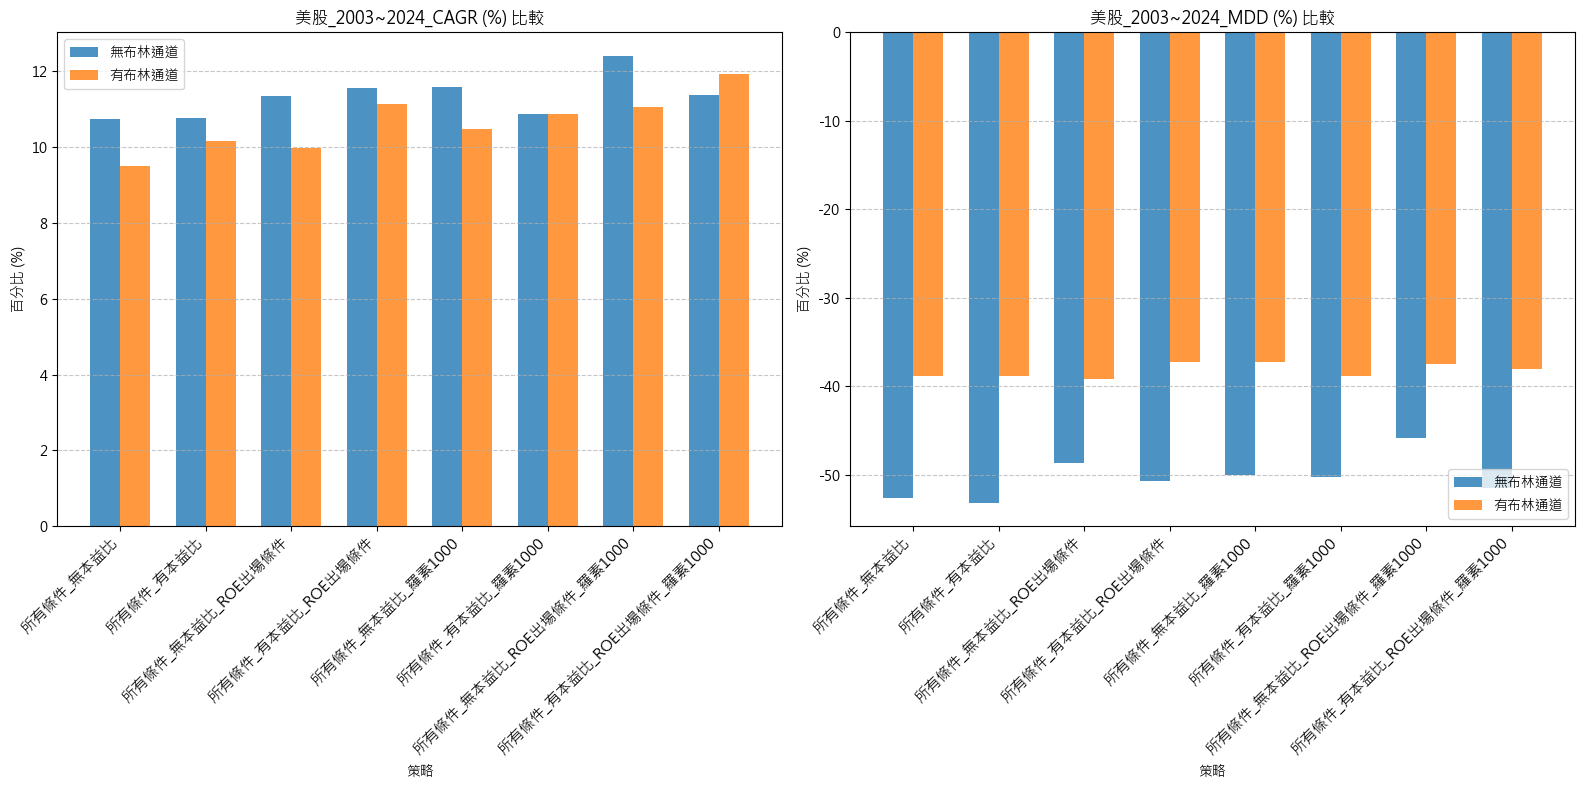

In [53]:
def plot_grouped_bolling_chart(russell_filt_df):

    df = russell_filt_df.copy()
    df.reset_index(inplace=True)
    
    # 創建新的欄位來標記是否包含布林通道
    df['has_bolling'] = df['Strategy'].str.contains('布林通道')
    
    # 獲取基本策略名稱（布林通道之前的部分）
    def get_base_strategy(strategy):
        if '布林通道' in strategy:
            return strategy.split('_布林通道')[0]
        return strategy
    
    df['base_strategy'] = df['Strategy'].apply(get_base_strategy)
    
    # 定義策略順序
    strategy_order = [
        "所有條件_無本益比",
        "所有條件_有本益比",
        "所有條件_無本益比_ROE出場條件",
        "所有條件_有本益比_ROE出場條件",
        "所有條件_無本益比_羅素1000",
        "所有條件_有本益比_羅素1000",
        "所有條件_無本益比_ROE出場條件_羅素1000",
        "所有條件_有本益比_ROE出場條件_羅素1000"
    ]
    
    # 按照指定順序篩選基本策略
    base_strategies = [s for s in strategy_order if s in df['base_strategy'].unique()]
    n_strategies = len(base_strategies)
    
    # 準備繪圖數據
    metrics = ['CAGR (%)', 'MDD (%)']
    
    # 設置圖形大小和樣式
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(max(16, n_strategies * 2), 8))
    bar_width = 0.35
    
    # 設置每組柱狀圖的位置
    indices = range(n_strategies)
    
    # 繪製分組柱狀圖
    for i, (metric, ax) in enumerate(zip(metrics, [ax1, ax2])):
        # 無布林通道的數據
        no_bolling_values = [
            df[(df['base_strategy'] == strategy) & (~df['has_bolling'])][metric].iloc[0]
            if len(df[(df['base_strategy'] == strategy) & (~df['has_bolling'])]) > 0
            else None
            for strategy in base_strategies
        ]
        
        # 有布林通道的數據
        with_bolling_values = [
            df[(df['base_strategy'] == strategy) & (df['has_bolling'])][metric].iloc[0]
            if len(df[(df['base_strategy'] == strategy) & (df['has_bolling'])]) > 0
            else None
            for strategy in base_strategies
        ]
        
        # 繪製柱狀圖
        ax.bar([x - bar_width/2 for x in indices],
               [v for v in no_bolling_values if v is not None],
               bar_width,
               label='無布林通道',
               alpha=0.8)
        
        ax.bar([x + bar_width/2 for x in indices],
               [v for v in with_bolling_values if v is not None],
               bar_width,
               label='有布林通道',
               alpha=0.8)
        
        # 設置圖表樣式
        ax.set_xlabel('策略')
        ax.set_ylabel('百分比 (%)')
        ax.set_title(f'美股_2003~2024_{metric} 比較')
        ax.set_xticks(indices)
        ax.set_xticklabels(base_strategies, rotation=45, ha='right', fontsize=11)
        ax.legend()
        ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # 調整版面配置
    plt.tight_layout()
    
    plt.show()


plot_grouped_bolling_chart(russell_filt_df)

---

## 比較是否考慮某項條件其對績效的影響

In [30]:
dataframes = {
    'roe_15': roe_cond,
    'rr_cond': rr_cond,
    'payout_ratio_cond': payout_cond,
    'profit_cond': netprofit_cond,
    'listed': listed_cond,
}

# 定義 DataFrame 對應的中文名稱
dataframe_names = {
    'roe_15': 'ROE五年平均',
    'rr_cond': '盈再率',
    'payout_ratio_cond': '配息率',
    'profit_cond': '稅後淨利',
    'hold_cond': '董監持股',
    'listed': '上市櫃滿兩年'
}


# 用於儲存組合結果
compare_conds_strat = {}

# 產生不同長度的組合
counter = 1
for r in range(1, len(dataframes) + 1):
    for combination in itertools.combinations(dataframes.keys(), r):
        # 計算DataFrame間的 AND 運算
        combined_signal = dataframes[combination[0]]
        for df_name in combination[1:]:
            combined_signal &= dataframes[df_name]

        # 限制日期區間
        combined_signal = CustomDataFrame(combined_signal)
        combined_signal = combined_signal[START_DATE:END_DATE]

        # 使用組合的中文名稱生成key_name
        key_name = "+".join([dataframe_names[df] for df in combination])

        # 將計算結果儲存到字典
        compare_conds_strat[key_name] = combined_signal
        counter += 1




compare_strat_collecs = sim_conditions(compare_conds_strat, resample='ME', data=data)

Backtesting progress: 100%|██████████| 31/31 [05:37<00:00, 10.88s/condition]


In [31]:
compare_strat_collecs_df = compare_strat_collecs.selected_stock_count_analysis()
# compare_strat_collecs_df.to_csv('./performance_file/US/美股_比較是否考慮某項條件其對績效的影響_無本益比進出場.csv', encoding="cp950")

包含本益比進出場

In [32]:
# 用於儲存組合結果
compare_conds_strat_PE={}

# 產生不同長度的組合，從1到6
counter = 1
for r in range(1, len(dataframes) + 1):
    for combination in itertools.combinations(dataframes.keys(), r):
        # 計算DataFrame間的 AND 運算
        combined_signal = dataframes[combination[0]]
        for df_name in combination[1:]:
            combined_signal &= dataframes[df_name]

        # 限制日期區間
        combined_signal = CustomDataFrame(combined_signal)
        combined_signal = (combined_signal[START_DATE:END_DATE] & daily_pe_entry[START_DATE:END_DATE]).hold_until((~combined_signal[START_DATE:END_DATE]) | daily_pe_exit[START_DATE:END_DATE])

        # 使用組合的中文名稱生成key_name
        key_name = "+".join([dataframe_names[df] for df in combination])

        # 將計算結果儲存到字典
        compare_conds_strat_PE[key_name] = combined_signal
        counter += 1


compare_strat_collecs_PE = sim_conditions(compare_conds_strat_PE, resample='ME', data=data)

Backtesting progress: 100%|██████████| 31/31 [04:21<00:00,  8.43s/condition]


In [33]:
compare_strat_collecs_PE_df = compare_strat_collecs_PE.selected_stock_count_analysis()
# compare_strat_collecs_PE_df.to_csv('./performance_file/US/美股_比較是否考慮某項條件其對績效的影響_本益比進出場.csv', encoding="cp950")

---

In [34]:
# 條件的字典
condition_dict = {
    'ROE五年平均': roe_cond,
    '盈再率': rr_cond,
    '三年配息率': payout_cond,
    '稅後淨利': netprofit_cond,
    '上市櫃滿兩年': listed_cond,
}

# 分離 "董監持股+上市櫃滿兩年" 與其他條件
additional_condition_key = '上市櫃滿兩年'
additional_condition = condition_dict.pop(additional_condition_key)

# 剩餘條件的 key
keys = list(condition_dict.keys())

# 創建交易訊號字典
signal_dict = {}

# 遍歷 2, 3, 4 的組合長度
for r in range(2, 5):
    combinations = itertools.combinations(keys, r)
    for combo in combinations:
        # 組合名稱
        combo_name = '+'.join(combo)

        # 條件的 AND 結果
        combined_condition = condition_dict[combo[0]]
        for key in combo[1:]:
            combined_condition &= condition_dict[key]

        # 加入不含 "董監持股+上市櫃滿兩年" 的組合
        signal_dict[combo_name] = combined_condition[START_DATE:END_DATE]

        # 加入含 "董監持股+上市櫃滿兩年" 的組合
        combo_name_with_additional = f"{combo_name}_{additional_condition_key}"
        signal_dict[combo_name_with_additional] = (combined_condition & additional_condition)[START_DATE:END_DATE]

# 添加本益比進出場的組合
pe_signal_dict = {}
for name, sig in signal_dict.items():
    # 原組合的本益比進出場
    pe_signal_dict[f"{name}_本益比進出場"] = (sig[START_DATE:END_DATE] & daily_pe_entry[START_DATE:END_DATE]).hold_until((~sig[START_DATE:END_DATE]) | daily_pe_exit[START_DATE:END_DATE])

    # 含 "董監持股+上市櫃滿兩年" 的組合的本益比進出場
    if additional_condition_key in name:
        pe_signal_dict[f"{name}_本益比進出場"] = (sig[START_DATE:END_DATE] & daily_pe_entry[START_DATE:END_DATE]).hold_until((~sig[START_DATE:END_DATE]) | daily_pe_exit[START_DATE:END_DATE])

# 合併所有組合
signal_dict.update(pe_signal_dict)

# 確認結果
for name, condition in signal_dict.items():
    print(name)

ROE五年平均+盈再率
ROE五年平均+盈再率_上市櫃滿兩年
ROE五年平均+三年配息率
ROE五年平均+三年配息率_上市櫃滿兩年
ROE五年平均+稅後淨利
ROE五年平均+稅後淨利_上市櫃滿兩年
盈再率+三年配息率
盈再率+三年配息率_上市櫃滿兩年
盈再率+稅後淨利
盈再率+稅後淨利_上市櫃滿兩年
三年配息率+稅後淨利
三年配息率+稅後淨利_上市櫃滿兩年
ROE五年平均+盈再率+三年配息率
ROE五年平均+盈再率+三年配息率_上市櫃滿兩年
ROE五年平均+盈再率+稅後淨利
ROE五年平均+盈再率+稅後淨利_上市櫃滿兩年
ROE五年平均+三年配息率+稅後淨利
ROE五年平均+三年配息率+稅後淨利_上市櫃滿兩年
盈再率+三年配息率+稅後淨利
盈再率+三年配息率+稅後淨利_上市櫃滿兩年
ROE五年平均+盈再率+三年配息率+稅後淨利
ROE五年平均+盈再率+三年配息率+稅後淨利_上市櫃滿兩年
ROE五年平均+盈再率_本益比進出場
ROE五年平均+盈再率_上市櫃滿兩年_本益比進出場
ROE五年平均+三年配息率_本益比進出場
ROE五年平均+三年配息率_上市櫃滿兩年_本益比進出場
ROE五年平均+稅後淨利_本益比進出場
ROE五年平均+稅後淨利_上市櫃滿兩年_本益比進出場
盈再率+三年配息率_本益比進出場
盈再率+三年配息率_上市櫃滿兩年_本益比進出場
盈再率+稅後淨利_本益比進出場
盈再率+稅後淨利_上市櫃滿兩年_本益比進出場
三年配息率+稅後淨利_本益比進出場
三年配息率+稅後淨利_上市櫃滿兩年_本益比進出場
ROE五年平均+盈再率+三年配息率_本益比進出場
ROE五年平均+盈再率+三年配息率_上市櫃滿兩年_本益比進出場
ROE五年平均+盈再率+稅後淨利_本益比進出場
ROE五年平均+盈再率+稅後淨利_上市櫃滿兩年_本益比進出場
ROE五年平均+三年配息率+稅後淨利_本益比進出場
ROE五年平均+三年配息率+稅後淨利_上市櫃滿兩年_本益比進出場
盈再率+三年配息率+稅後淨利_本益比進出場
盈再率+三年配息率+稅後淨利_上市櫃滿兩年_本益比進出場
ROE五年平均+盈再率+三年配息率+稅後淨利_本益比進出場
ROE五年平均+盈再率+三年配息率+稅後淨利_上市櫃滿兩年_本益比進出場


In [35]:
signal_dict_comb = sim_conditions(signal_dict, resample='ME', data=data)
signal_dict_comb.selected_stock_count_analysis()

Backtesting progress: 100%|██████████| 44/44 [06:05<00:00,  8.30s/condition]


CAGR (%)  MDD (%)  入選股數平均    中位數  \
Strategy                                                                 
ROE五年平均+盈再率                              14.58   -51.87  295.56  293.0   
ROE五年平均+盈再率_上市櫃滿兩年                       14.36   -52.02  290.42  289.0   
ROE五年平均+盈再率_本益比進出場                       13.66   -53.53  167.51  178.0   
ROE五年平均+盈再率_上市櫃滿兩年_本益比進出場                13.55   -53.95  164.50  176.0   
ROE五年平均+盈再率+稅後淨利                         12.88   -52.45  238.37  221.0   
ROE五年平均+稅後淨利                             12.68   -53.93  339.03  312.0   
ROE五年平均+盈再率+稅後淨利_上市櫃滿兩年                  12.67   -52.79  234.71  218.0   
ROE五年平均+稅後淨利_上市櫃滿兩年                      12.66   -53.84  331.45  299.5   
ROE五年平均+稅後淨利_本益比進出場                      12.61   -55.66  210.60  212.5   
盈再率+稅後淨利                                 12.57   -56.12  471.01  461.0   
盈再率+稅後淨利_上市櫃滿兩年                          12.48   -56.22  464.30  455.0   
ROE五年平均+稅後淨利_上市櫃滿兩年_本益比進出場               12.45   -55.68  206.07  208.0   
盈再率+稅後淨利_本益比進出場                          12.38   -57.38  278.42  304.0   
ROE五年平均+盈再率+稅後淨利_本益比進出場                  12.37   -54.84  139.39  151.0   
盈再率+稅後淨利_上市櫃滿兩年_本益比進出場                   12.37   -57.48  273.79  300.0   
ROE五年平均+盈再率+稅後淨利_上市櫃滿兩年_本益比進出場           12.32   -55.30  137.15  150.0   
ROE五年平均+三年配息率_上市櫃滿兩年                     11.37   -49.16   68.63   61.0   
ROE五年平均+盈再率+三年配息率_上市櫃滿兩年                 11.34   -49.62   50.29   48.0   
ROE五年平均+盈再率+三年配息率                        11.33   -49.31   50.57   48.0   
ROE五年平均+盈再率+三年配息率_本益比進出場                 11.29   -49.38   27.85   28.0   
盈再率+三年配息率_本益比進出場                         11.21   -48.73   69.55   66.0   
ROE五年平均+三年配息率                            11.16   -49.06   69.55   62.0   
ROE五年平均+盈再率+三年配息率_上市櫃滿兩年_本益比進出場          11.14   -49.68   27.73   28.0   
盈再率+三年配息率_上市櫃滿兩年_本益比進出場                  11.13   -48.85   69.15   66.0   
ROE五年平均+三年配息率+稅後淨利_上市櫃滿兩年                11.11   -53.09   55.71   48.0   
ROE五年平均+三年配息率_上市櫃滿兩年_本益比進出場              11.03   -49.62   39.64   40.0   
盈再率+三年配息率                                11.03   -48.10  129.27  115.0   
ROE五年平均+三年配息率+稅後淨利_上市櫃滿兩年_本益比進出場         10.98   -54.44   32.16   31.0   
盈再率+三年配息率_上市櫃滿兩年                         10.98   -48.23  128.25  114.0   
ROE五年平均+三年配息率+稅後淨利                       10.97   -53.48   56.11   48.0   
ROE五年平均+三年配息率_本益比進出場                     10.91   -49.52   40.02   40.0   
ROE五年平均+三年配息率+稅後淨利_本益比進出場                10.79   -54.87   32.32   32.0   
ROE五年平均+盈再率+三年配息率+稅後淨利                   10.78   -52.07   41.87   37.0   
ROE五年平均+盈再率+三年配息率+稅後淨利_上市櫃滿兩年            10.75   -52.54   41.71   37.0   
ROE五年平均+盈再率+三年配息率+稅後淨利_本益比進出場            10.71   -52.57   23.10   24.0   
ROE五年平均+盈再率+三年配息率+稅後淨利_上市櫃滿兩年_本益比進出場     10.69   -53.05   23.01   24.0   
盈再率+三年配息率+稅後淨利_本益比進出場                    10.39   -51.82   45.29   43.0   
盈再率+三年配息率+稅後淨利_上市櫃滿兩年_本益比進出場             10.30   -52.30   45.08   42.0   
三年配息率+稅後淨利_本益比進出場                        10.20   -57.47  101.01   94.0   
三年配息率+稅後淨利_上市櫃滿兩年_本益比進出場                 10.15   -57.88   98.63   91.5   
盈再率+三年配息率+稅後淨利                           10.09   -52.46   85.49   77.0   
盈再率+三年配息率+稅後淨利_上市櫃滿兩年                     9.99   -52.95   84.97   76.0   
三年配息率+稅後淨利                                9.96   -57.86  166.54  164.0   
三年配息率+稅後淨利_上市櫃滿兩年                         9.92   -58.25  163.37  158.0   

                                         25%     75%    Min    Max  
Strategy                                                            
ROE五年平均+盈再率                           259.00  353.75  179.0  447.0  
ROE五年平均+盈再率_上市櫃滿兩年                    256.25  348.00  174.0  445.0  
ROE五年平均+盈再率_本益比進出場                    141.00  188.00   98.0  279.0  
ROE五年平均+盈再率_上市櫃滿兩年_本益比進出場             136.25  186.00   97.0  272.0  
ROE五年平均+盈再率+稅後淨利                      196.00  304.00  111.0  388.0  
ROE五年平均+稅後淨利                          276.25  409.00  179.0  528.0  
ROE五年平均+盈再率+稅後淨利_上市櫃滿兩年               194.00  298.75  109.0  386.0  
ROE五年平均+稅後淨利

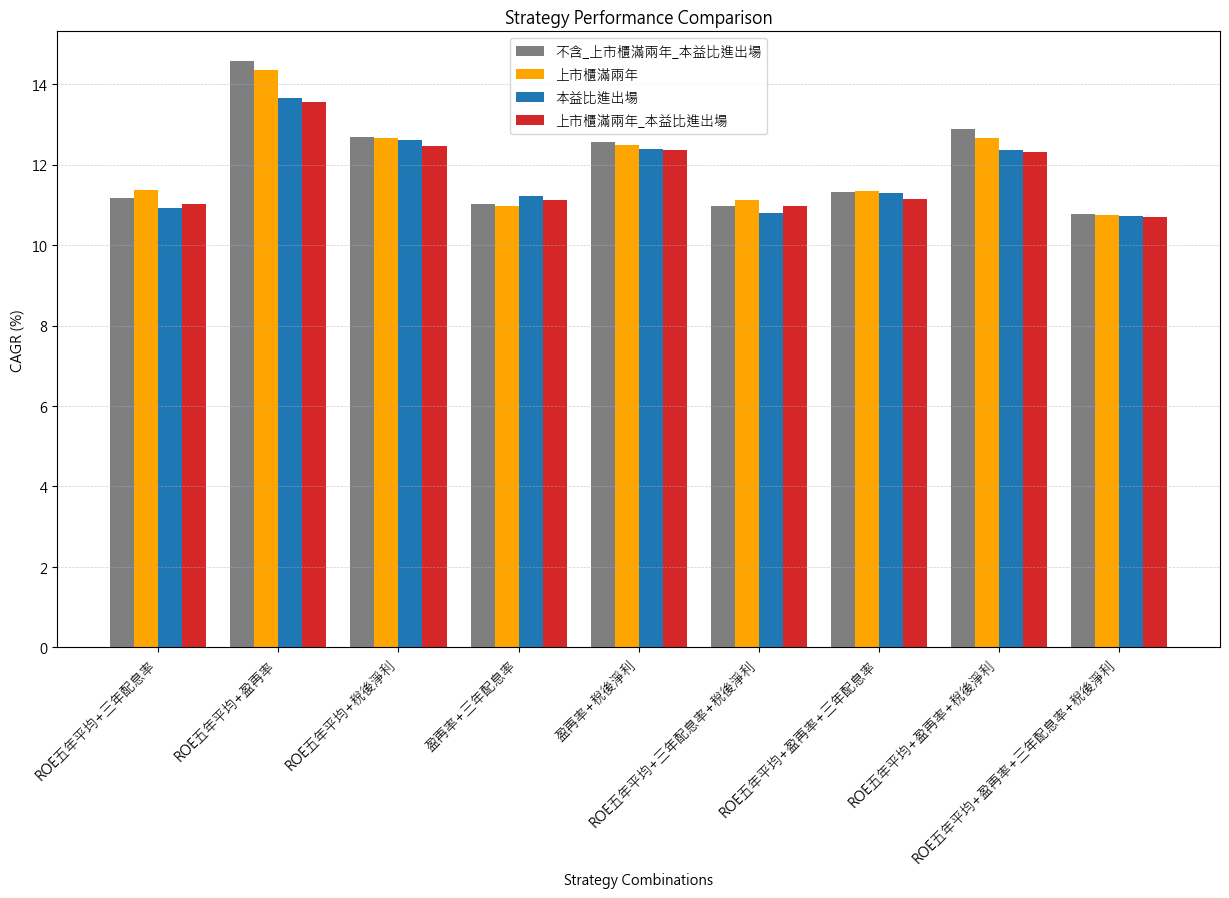

In [58]:
df = signal_dict_comb.selected_stock_count_analysis()
df.reset_index(inplace=True)

# 先找出基準策略的CAGR
baseline_strategy = "ROE五年平均+盈再率+三年配息率+稅後淨利_上市櫃滿兩年_本益比進出場"
baseline_cagr = df.loc[df['Strategy'] == baseline_strategy, 'CAGR (%)'].values[0]

# 找出所有績效較好的策略
better_strategies = df[df['CAGR (%)'] >= baseline_cagr].copy()

# 處理Strategy名稱，分離因子組合和後綴
def process_strategy(strategy):
    # 分離後綴
    suffixes = []
    if '_上市櫃滿兩年_本益比進出場' in strategy:
        base = strategy.replace('_上市櫃滿兩年_本益比進出場', '')
        suffix_type = 'both'
    elif '_上市櫃滿兩年' in strategy:
        base = strategy.replace('_上市櫃滿兩年', '')
        suffix_type = 'listed'
    elif '_本益比進出場' in strategy:
        base = strategy.replace('_本益比進出場', '')
        suffix_type = 'pe'
    else:
        base = strategy
        suffix_type = 'none'
    
    # 計算因子數量
    factor_count = len(base.split('+'))
    
    return pd.Series({
        'base_strategy': base,
        'suffix_type': suffix_type,
        'factor_count': factor_count
    })

# 添加處理後的列
better_strategies = pd.concat([
    better_strategies,
    better_strategies['Strategy'].apply(process_strategy)
], axis=1)

# 排序資料
better_strategies = better_strategies.sort_values(['factor_count', 'base_strategy', 'suffix_type'])

# 設定圖表樣式
# plt.style.use('seaborn')
plt.figure(figsize=(15, 8))

# 設定bar的寬度和位置
bar_width = 0.2
suffix_types = ['none', 'listed', 'pe', 'both']
colors = ['tab:gray', 'orange', 'tab:blue', 'tab:red']
positions = np.arange(len(better_strategies['base_strategy'].unique()))

# 繪製grouped bar chart
for i, (suffix, color) in enumerate(zip(suffix_types, colors)):
    mask = better_strategies['suffix_type'] == suffix
    data = better_strategies[mask].set_index('base_strategy')['CAGR (%)']
    plt.bar(positions + i * bar_width, 
            [data.get(strategy, 0) for strategy in better_strategies['base_strategy'].unique()],
            bar_width,
            label=suffix,
            color=color)

# 設定圖表標籤
plt.xlabel('Strategy Combinations')
plt.ylabel('CAGR (%)')
plt.title('Strategy Performance Comparison')
plt.xticks(positions + bar_width * 1.5, 
          better_strategies['base_strategy'].unique(), 
          rotation=45,
          ha='right')

# 添加圖例
plt.legend(['不含_上市櫃滿兩年_本益比進出場', 
            '上市櫃滿兩年', 
            '本益比進出場', 
            '上市櫃滿兩年_本益比進出場'])

plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.6)

# # 調整版面
# plt.tight_layout()

# 顯示圖表
plt.show()

In [36]:
pd.options.display.float_format = '{:.2f}'.format


def analyze_signal_groups(signal_dict_comb):
    # 初始化結果字典
    results = {
        '包含ROE五年平均': [],
        '包含盈再率': [],
        '包含配息率': [],
        '包含稅後淨利': [],
        # '包含董監持股+上市櫃滿兩年': []
    }

    # 遍歷策略並分類
    for strategy in signal_dict_comb.index:
        if 'ROE五年平均' in strategy:
            results['包含ROE五年平均'].append(strategy)
        if '盈再率' in strategy:
            results['包含盈再率'].append(strategy)
        if '三年配息率' in strategy:
            results['包含配息率'].append(strategy)
        if '稅後淨利' in strategy:
            results['包含稅後淨利'].append(strategy)
        # if '董監持股+上市櫃滿兩年' in strategy:
        #     results['包含董監持股+上市櫃滿兩年'].append(strategy)

    # 計算每組的平均值，細分為包含/不包含條件、有/無本益比進出場、綜合
    summary_data = []
    for group, strategies in results.items():
        condition_name = group.split('包含')[1]

        # 包含條件與不包含條件
        for include_condition in [True, False]:
            filtered_strategies_condition = [s for s in signal_dict_comb.index if (condition_name in s) == include_condition]

            # 細分有/無本益比進出場
            for include_pe in [True, False]:
                filtered_strategies = [s for s in filtered_strategies_condition if ('本益比進出場' in s) == include_pe]
                if filtered_strategies:
                    filtered_df = signal_dict_comb.loc[filtered_strategies]
                    avg_cagr = filtered_df['CAGR (%)'].mean()
                    avg_mdd = filtered_df['MDD (%)'].mean()
                    avg_selected_stock = filtered_df['入選股數平均'].mean()
                    condition_label = f"{'包含' if include_condition else '不包含'}{condition_name} ({'含本益比進出場' if include_pe else '不含本益比進出場'})"
                    summary_data.append([condition_label, avg_cagr, avg_mdd, avg_selected_stock])

            # 綜合分析
            combined_df = signal_dict_comb.loc[filtered_strategies_condition]
            if not combined_df.empty:
                avg_cagr_combined = combined_df['CAGR (%)'].mean()
                avg_mdd_combined = combined_df['MDD (%)'].mean()
                avg_selected_stock_combined = combined_df['入選股數平均'].mean()
                condition_label = f"{'包含' if include_condition else '不包含'}{condition_name} (綜合)"
                summary_data.append([condition_label, avg_cagr_combined, avg_mdd_combined, avg_selected_stock_combined])

    # 返回新的 DataFrame
    summary_df = pd.DataFrame(summary_data, columns=['Group', 'Average CAGR (%)', 'Average MDD (%)', 'Average Selected Stock Count'])
    return summary_df

# signal_dict_comb = sim_conditions(signal_dict, resample='ME', data=data)
summary_df = analyze_signal_groups(signal_dict_comb.selected_stock_count_analysis())
summary_df

Group  Average CAGR (%)  Average MDD (%)  \
0     包含ROE五年平均 (含本益比進出場)             11.75           -53.01   
1    包含ROE五年平均 (不含本益比進出場)             12.05           -51.80   
2          包含ROE五年平均 (綜合)             11.90           -52.40   
3    不包含ROE五年平均 (含本益比進出場)             11.02           -53.99   
4   不包含ROE五年平均 (不含本益比進出場)             10.88           -53.77   
5         不包含ROE五年平均 (綜合)             10.95           -53.88   
6         包含盈再率 (含本益比進出場)             11.68           -52.78   
7        包含盈再率 (不含本益比進出場)             11.85           -51.91   
8              包含盈再率 (綜合)             11.76           -52.34   
9        不包含盈再率 (含本益比進出場)             11.14           -54.39   
10      不包含盈再率 (不含本益比進出場)             11.23           -53.58   
11            不包含盈再率 (綜合)             11.18           -53.99   
12        包含配息率 (含本益比進出場)             10.78           -52.16   
13       包含配息率 (不含本益比進出場)             10.77           -51.87   
14             包含配息率 (綜合)             10.78           -52.01   
15       不包含配息率 (含本益比進出場)             12.71           -55.48   
16      不包含配息率 (不含本益比進出場)             13.11           -53.66   
17            不包含配息率 (綜合)             12.91           -54.57   
18       包含稅後淨利 (含本益比進出場)             11.34           -55.05   
19      包含稅後淨利 (不含本益比進出場)             11.39           -54.15   
20            包含稅後淨利 (綜合)             11.36           -54.60   
21      不包含稅後淨利 (含本益比進出場)             11.74           -50.41   
22     不包含稅後淨利 (不含本益比進出場)             12.02           -49.67   
23           不包含稅後淨利 (綜合)             11.88           -50.04   

    Average Selected Stock Count  
0                          90.79  
1                         154.57  
2                         122.68  
3                         122.62  
4                         211.65  
5                         167.13  
6                         106.54  
7                         186.20  
8                         146.37  
9                          95.06  
10                        156.30  
11                        125.68  
12                         48.18  
13                         85.17  
14                         66.67  
15                        197.18  
16                        333.11  
17                        265.14  
18                        117.57  
19                        198.19  
20                        157.88  
21                         75.74  
22                        135.32  
23                        105.53

### 繪圖

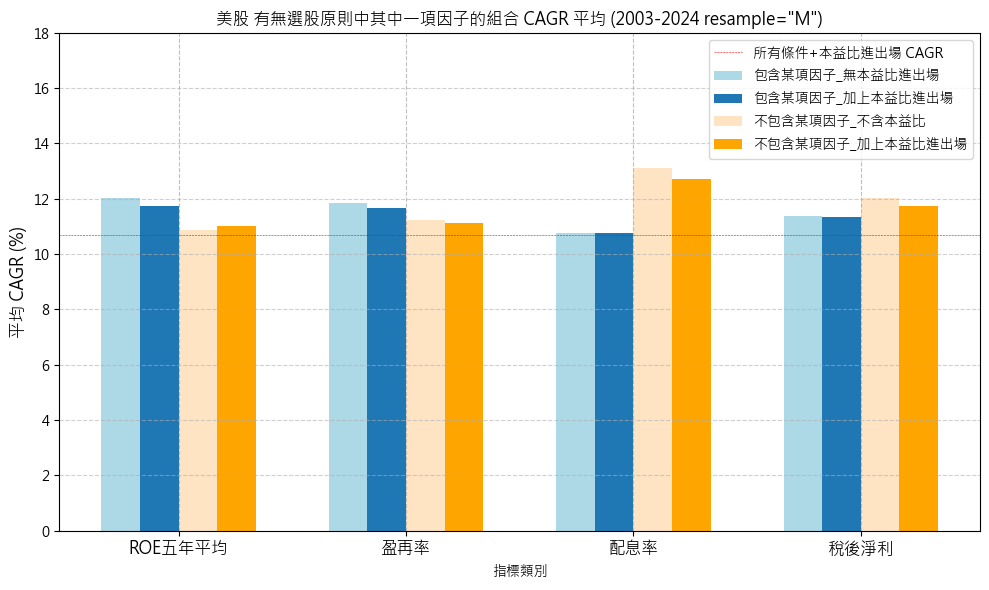

In [42]:
# 創建DataFrame
df = summary_df.copy()

# # 處理數據：提取所需的行（包含/不包含且是含本益比進出場的組合）
# mask = df['Group'].str.contains('含本益比進出場')
# filtered_df = df[mask].copy()

# # 定義類別順序
# categories = ['ROE五年平均', '盈再率', '配息率', '稅後淨利']

# # 創建類別對應的數據
# included_values = []
# excluded_values = []

# for category in categories:
#     # 獲取包含該類別的資料
#     included_mask = filtered_df['Group'].str.contains(f'包含{category}')
#     excluded_mask = filtered_df['Group'].str.contains(f'不包含{category}')
    
#     included_value = filtered_df[included_mask]['Average CAGR (%)'].values[0]
#     excluded_value = filtered_df[excluded_mask]['Average CAGR (%)'].values[0]
    
#     included_values.append(included_value)
#     excluded_values.append(excluded_value)

# # 設置圖表風格和大小
# # plt.style.use('seaborn')
# plt.figure(figsize=(14, 6))

# # 設置bar的寬度
# width = 0.17

# # 設置x軸位置
# x = np.arange(len(categories))

# # 繪製條形圖
# bars1 = plt.bar(x - width/2, included_values, width, label='包含', color='tab:blue')
# bars2 = plt.bar(x + width/2, excluded_values, width, label='不包含', color='orange')

# # 設置圖表標題和標籤
# plt.title('台股 有無選股原則中其中一項因子的組合 CAGR 平均 (含本益比進出場)', fontsize=12)
# plt.xlabel('指標類別')
# plt.ylabel('Average CAGR (%)')

# # 設置x軸刻度和標籤
# plt.xticks(x, categories)

# # 設置y軸範圍
# plt.ylim(0, 16)

# # 添加網格線
# plt.grid(True, linestyle='--', alpha=0.8)

# benchmark_value = signal_dict_comb.selected_stock_count_analysis().loc['ROE五年平均+盈再率+三年配息率+稅後淨利_董監持股+上市櫃滿兩年_本益比進出場']['CAGR (%)']
# plt.axhline(y=benchmark_value, color='red', linestyle='--', label='所有條件+本益比進出場 CAGR', linewidth=0.3)

# # 添加圖例
# plt.legend(loc='upper center', bbox_to_anchor=(1.15, 1), fontsize=10)

# # 調整布局
# plt.tight_layout()

# # 顯示圖表
# plt.show()

# 定義類別順序
categories = ['ROE五年平均', '盈再率', '配息率', '稅後淨利']

# 創建類別對應的數據
included_no_pe_values = []  # 包含但不含本益比
included_with_pe_values = []  # 包含且含本益比
excluded_no_pe_values = []  # 不包含且不含本益比
excluded_with_pe_values = []  # 不包含且含本益比

for category in categories:
    # 包含且不含本益比
    mask_included_no_pe = df['Group'].str.contains(f'包含{category} \(不含本益比進出場\)')
    included_no_pe_values.append(df[mask_included_no_pe]['Average CAGR (%)'].values[0])
    
    # 包含且含本益比
    mask_included_with_pe = df['Group'].str.contains(f'包含{category} \(含本益比進出場\)')
    included_with_pe_values.append(df[mask_included_with_pe]['Average CAGR (%)'].values[0])
    
    # 不包含且不含本益比
    mask_excluded_no_pe = df['Group'].str.contains(f'不包含{category} \(不含本益比進出場\)')
    excluded_no_pe_values.append(df[mask_excluded_no_pe]['Average CAGR (%)'].values[0])
    
    # 不包含且含本益比
    mask_excluded_with_pe = df['Group'].str.contains(f'不包含{category} \(含本益比進出場\)')
    excluded_with_pe_values.append(df[mask_excluded_with_pe]['Average CAGR (%)'].values[0])

# 設置圖表大小
plt.figure(figsize=(10, 6))

# 設置bar的寬度
width = 0.17

# 設置x軸位置
x = np.arange(len(categories))

# 繪製條形圖
bars1 = plt.bar(x - width*1.5, included_no_pe_values, width, 
                label='包含某項因子_無本益比進出場', color='lightblue')
bars2 = plt.bar(x - width/2, included_with_pe_values, width, 
                label='包含某項因子_加上本益比進出場', color='tab:blue')
bars3 = plt.bar(x + width/2, excluded_no_pe_values, width, 
                label='不包含某項因子_不含本益比', color='bisque')
bars4 = plt.bar(x + width*1.5, excluded_with_pe_values, width, 
                label='不包含某項因子_加上本益比進出場', color='orange')

# 設置圖表標題和標籤
plt.title('美股 有無選股原則中其中一項因子的組合 CAGR 平均 (2003-2024 resample="M")', fontsize=12)
plt.xlabel('指標類別')
plt.ylabel('平均 CAGR (%)', fontsize=12)

# 設置x軸刻度和標籤
plt.xticks(x, categories, fontsize=12)

# 設置y軸範圍
plt.ylim(0, 18)

# # 添加網格線
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.grid(axis='x', linestyle='--', alpha=0.8)

# 添加基準線
benchmark_value = signal_dict_comb.selected_stock_count_analysis().loc['ROE五年平均+盈再率+三年配息率+稅後淨利_上市櫃滿兩年_本益比進出場']['CAGR (%)']
plt.axhline(y=benchmark_value, color='red', linestyle='--', 
            label='所有條件+本益比進出場 CAGR', linewidth=0.4)

# # 在bar上添加數值標籤
# def add_value_labels(bars):
#     for bar in bars:
#         height = bar.get_height()
#         plt.text(bar.get_x() + bar.get_width()/2., height,
#                 f'{height:.2f}%',
#                 ha='center', va='bottom',
#                 fontsize=8)

# add_value_labels(bars1)
# add_value_labels(bars2)
# add_value_labels(bars3)
# add_value_labels(bars4)

# 添加圖例
plt.legend()

# 調整布局
plt.tight_layout()

# 顯示圖表
plt.show()

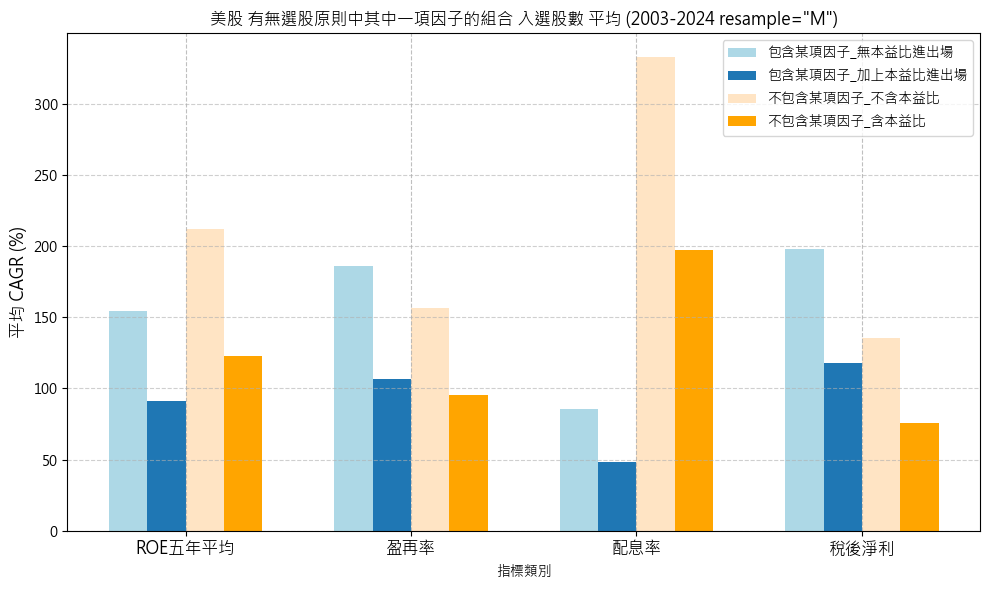

In [43]:
# 創建DataFrame
df = summary_df.copy()


# 定義類別順序
categories = ['ROE五年平均', '盈再率', '配息率', '稅後淨利']

# 創建類別對應的數據
included_no_pe_values = []  # 包含但不含本益比
included_with_pe_values = []  # 包含且含本益比
excluded_no_pe_values = []  # 不包含且不含本益比
excluded_with_pe_values = []  # 不包含且含本益比

for category in categories:
    # 包含且不含本益比
    mask_included_no_pe = df['Group'].str.contains(f'包含{category} \(不含本益比進出場\)')
    included_no_pe_values.append(df[mask_included_no_pe]['Average Selected Stock Count'].values[0])
    
    # 包含且含本益比
    mask_included_with_pe = df['Group'].str.contains(f'包含{category} \(含本益比進出場\)')
    included_with_pe_values.append(df[mask_included_with_pe]['Average Selected Stock Count'].values[0])
    
    # 不包含且不含本益比
    mask_excluded_no_pe = df['Group'].str.contains(f'不包含{category} \(不含本益比進出場\)')
    excluded_no_pe_values.append(df[mask_excluded_no_pe]['Average Selected Stock Count'].values[0])
    
    # 不包含且含本益比
    mask_excluded_with_pe = df['Group'].str.contains(f'不包含{category} \(含本益比進出場\)')
    excluded_with_pe_values.append(df[mask_excluded_with_pe]['Average Selected Stock Count'].values[0])

# 設置圖表大小
plt.figure(figsize=(10, 6))

# 設置bar的寬度
width = 0.17

# 設置x軸位置
x = np.arange(len(categories))

# 繪製條形圖
bars1 = plt.bar(x - width*1.5, included_no_pe_values, width, 
                label='包含某項因子_無本益比進出場', color='lightblue')
bars2 = plt.bar(x - width/2, included_with_pe_values, width, 
                label='包含某項因子_加上本益比進出場', color='tab:blue')
bars3 = plt.bar(x + width/2, excluded_no_pe_values, width, 
                label='不包含某項因子_不含本益比', color='bisque')
bars4 = plt.bar(x + width*1.5, excluded_with_pe_values, width, 
                label='不包含某項因子_含本益比', color='orange')

# 設置圖表標題和標籤
plt.title('美股 有無選股原則中其中一項因子的組合 入選股數 平均 (2003-2024 resample="M")', fontsize=12)
plt.xlabel('指標類別')
plt.ylabel('平均 CAGR (%)', fontsize=12)

# 設置x軸刻度和標籤
plt.xticks(x, categories, fontsize=12)

# # 設置y軸範圍
# plt.ylim(0, 16)

# # 添加網格線
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.grid(axis='x', linestyle='--', alpha=0.8)



# 添加圖例
plt.legend()

# 調整布局
plt.tight_layout()

# 顯示圖表
plt.show()

In [39]:
# # 創建DataFrame
# df = summary_df

# # 設定中文字型
# plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
# plt.rcParams['axes.unicode_minus'] = False

# # 處理數據：提取所需的行（包含/不包含且是含本益比進出場的組合）
# mask = df['Group'].str.contains('不含本益比進出場')
# filtered_df = df[mask].copy()

# # 定義類別順序
# categories = ['ROE五年平均', '盈再率', '配息率', '稅後淨利']

# # 創建類別對應的數據
# included_values = []
# excluded_values = []

# for category in categories:
#     # 獲取包含該類別的資料
#     included_mask = filtered_df['Group'].str.contains(f'包含{category}')
#     excluded_mask = filtered_df['Group'].str.contains(f'不包含{category}')
    
#     included_value = filtered_df[included_mask]['Average CAGR (%)'].values[0]
#     excluded_value = filtered_df[excluded_mask]['Average CAGR (%)'].values[0]
    
#     included_values.append(included_value)
#     excluded_values.append(excluded_value)

# # 設置圖表風格和大小
# # plt.style.use('seaborn')
# plt.figure(figsize=(14, 5))

# # 設置bar的寬度
# width = 0.17

# # 設置x軸位置
# x = np.arange(len(categories))

# # 繪製條形圖
# bars1 = plt.bar(x - width/2, included_values, width, label='包含', color='tab:blue')
# bars2 = plt.bar(x + width/2, excluded_values, width, label='不包含', color='orange')

# # 設置圖表標題和標籤
# plt.title('台股 有無選股原則中其中一項因子的組合 CAGR 平均 (不含本益比進出場)', fontsize=12)
# plt.xlabel('指標類別')
# plt.ylabel('Average CAGR (%)')

# # 設置x軸刻度和標籤
# plt.xticks(x, categories)



# # 設置y軸範圍
# plt.ylim(0, 16)

# # 添加網格線
# plt.grid(True, linestyle='--', alpha=0.8)

# benchmark_value=signal_dict_comb.selected_stock_count_analysis().loc['ROE五年平均+盈再率+三年配息率+稅後淨利_董監持股+上市櫃滿兩年']['CAGR (%)']
# plt.axhline(y=benchmark_value, color='red', linestyle='--', label='所有條件_沒有本益比進出場CAGR', linewidth=0.3)

# # 添加圖例
# plt.legend(loc='upper center', bbox_to_anchor=(1.15, 1), fontsize=12)


# # 調整布局
# plt.tight_layout()

# # 顯示圖表
# plt.show()

---

## TODO

---

### 其他條件固定，ROE參數最佳化

In [46]:
roe_value_cond = {}
no_roe_conds = (rr_cond & netprofit_cond & payout_cond & listed_cond)[START_DATE:END_DATE]

for i in range(10, 31, 5): # 大於 10~25%
    for n in range(3, 6): # 3, 4, 5年平均
        

        # ROE 5年平均 > 15%
        roe_opt_df = roe.copy()
        # 提取index的月份
        roe_opt_df['month'] = roe_opt_df.index.month
        # 依據月份分組，對每個月份的每5年計算平均
        roe_df_result = roe_opt_df.groupby('month', group_keys=False).apply(lambda group: group.rolling(n, min_periods=n).mean(), include_groups=False)

        roe_cond_opt = (roe_rol > (i/100))[START_DATE:END_DATE]

        roe_value_cond[f'roe_{n}y_{i}_無本益比進出場'] = (roe_cond_opt & no_roe_conds)[START_DATE:END_DATE]
        roe_value_cond[f'roe_{n}y_{i}_有本益比進出場'] = ((roe_cond_opt & no_roe_conds & daily_pe_entry[START_DATE:END_DATE]).hold_until((~(roe_cond_opt & no_roe_conds)) | daily_pe_exit[START_DATE:END_DATE]))
        
roe_collection = sim_conditions(roe_value_cond, resample='ME', data=data)
roe_collection.selected_stock_count_analysis()

Backtesting progress: 100%|██████████| 30/30 [01:32<00:00,  3.10s/condition]


CAGR (%)  MDD (%)  入選股數平均   中位數   25%   75%   Min    Max
Strategy                                                                   
roe_5y_30_有本益比進出場     12.80   -52.62    9.35  9.00  7.00 12.00  3.00  20.00
roe_4y_30_有本益比進出場     12.80   -52.62    9.35  9.00  7.00 12.00  3.00  20.00
roe_3y_30_有本益比進出場     12.80   -52.62    9.35  9.00  7.00 12.00  3.00  20.00
roe_5y_25_有本益比進出場     12.67   -48.88   11.85 12.00 10.00 14.00  5.00  24.00
roe_4y_25_有本益比進出場     12.67   -48.88   11.85 12.00 10.00 14.00  5.00  24.00
roe_3y_25_有本益比進出場     12.67   -48.88   11.85 12.00 10.00 14.00  5.00  24.00
roe_5y_25_無本益比進出場     12.13   -45.93   22.42 20.00 11.25 32.00  7.00  46.00
roe_4y_25_無本益比進出場     12.13   -45.93   22.42 20.00 11.25 32.00  7.00  46.00
roe_3y_25_無本益比進出場     12.13   -45.93   22.42 20.00 11.25 32.00  7.00  46.00
roe_5y_30_無本益比進出場     11.80   -47.42   16.90 17.00  8.25 25.00  5.00  33.00
roe_4y_30_無本益比進出場     11.80   -47.42   16.90 17.00  8.25 25.00  5.00  33.00
roe_3y_30_無本益比進出場     11.80   -47.42   16.90 17.00  8.25 25.00  5.00  33.00
roe_5y_20_無本益比進出場     11.06   -47.59   30.26 31.00 17.00 43.00 10.00  53.00
roe_3y_20_無本益比進出場     11.06   -47.59   30.26 31.00 17.00 43.00 10.00  53.00
roe_4y_20_無本益比進出場     11.06   -47.59   30.26 31.00 17.00 43.00 10.00  53.00
roe_5y_20_有本益比進出場     10.99   -49.99   16.53 17.00 14.00 19.00  8.00  28.00
roe_4y_20_有本益比進出場     10.99   -49.99   16.53 17.00 14.00 19.00  8.00  28.00
roe_3y_20_有本益比進出場     10.99   -49.99   16.53 17.00 14.00 19.00  8.00  28.00
roe_3y_10_有本益比進出場     10.78   -51.46   33.27 33.00 25.00 40.00 18.00  55.00
roe_5y_10_有本益比進出場     10.78   -51.46   33.27 33.00 25.00 40.00 18.00  55.00
roe_4y_10_有本益比進出場     10.78   -51.46   33.27 33.00 25.00 40.00 18.00  55.00
roe_5y_10_無本益比進出場     10.76   -52.38   58.23 53.50 35.00 79.00 20.00 108.00
roe_4y_10_無本益比進出場     10.76   -52.38   58.23 53.50 35.00 79.00 20.00 108.00
roe_3y_10_無本益比進出場     10.76   -52.38   58.23 53.50 35.00 79.00 20.00 108.00
roe_5y_15_無本益比進出場     10.75   -52.54   41.71 37.00 28.00 58.00 14.00  75.00
roe_4y_15_無本益比進出場     10.75   -52.54   41.71 37.00 28.00 58.00 14.00  75.00
roe_3y_15_無本益比進出場     10.75   -52.54   41.71 37.00 28.00 58.00 14.00  75.00
roe_5y_15_有本益比進出場     10.69   -53.05   23.01 24.00 18.00 28.00 12.00  42.00
roe_4y_15_有本益比進出場     10.69   -53.05   23.01 24.00 18.00 28.00 12.00  42.00
roe_3y_15_有本益比進出場     10.69   -53.05   23.01 24.00 18.00 28.00 12.00  42.00

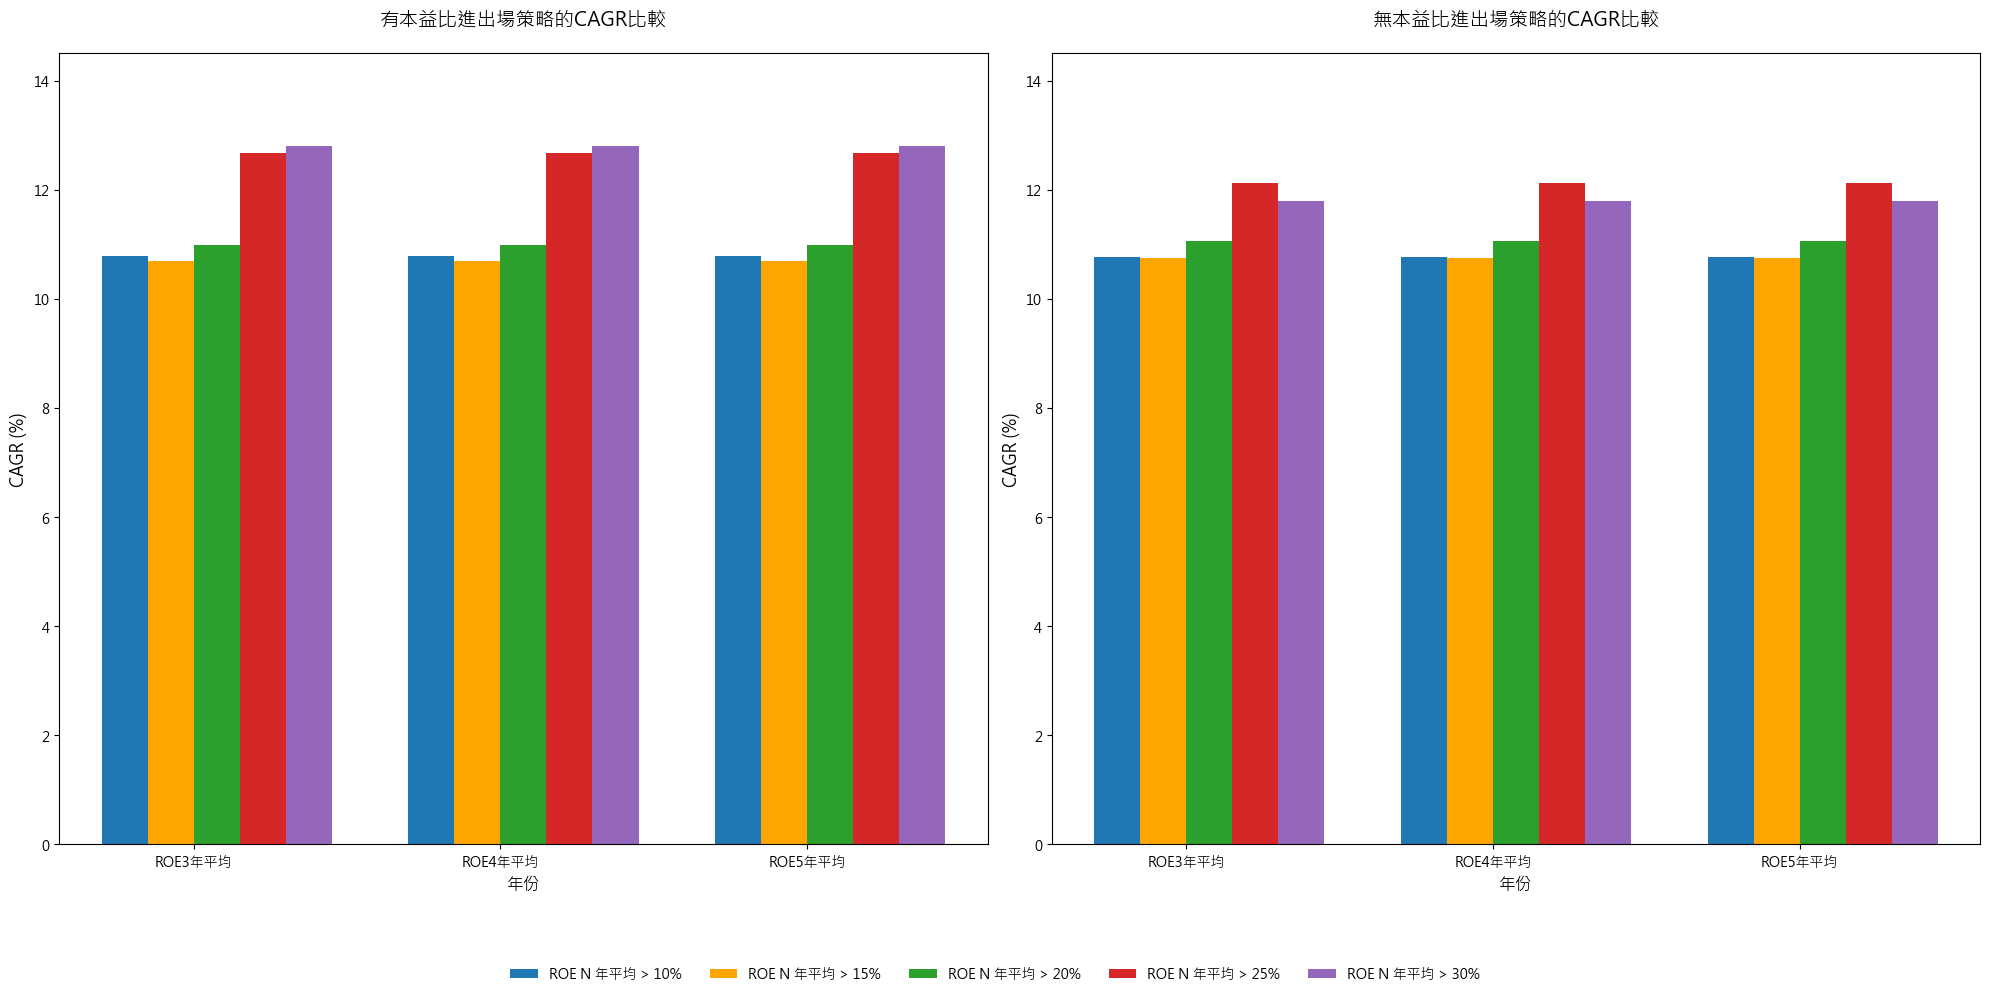

In [50]:
roe_collection_df = roe_collection.selected_stock_count_analysis()
roe_collection_df.reset_index(inplace=True)


# 建立顏色映射
colors = {
    '10': 'tab:blue',
    '15': 'orange',
    '20': 'tab:green',
    '25': 'tab:red', 
    '30': 'tab:purple'
}

# 提取年份和ROE閾值
roe_collection_df['Year'] = roe_collection_df['Strategy'].str.extract(r'roe_(\d)y')
roe_collection_df['ROE'] = roe_collection_df['Strategy'].str.extract(r'_(\d+)_')
roe_collection_df['PE'] = roe_collection_df['Strategy'].str.contains('有本益比')

# 創建子圖，設定比例為1:2，並留出下方空間給legend
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# 獲取唯一的年份值
years = sorted(roe_collection_df['Year'].unique())

# 設定長條的寬度
bar_width = 0.15

# 計算每個年份組的位置
positions = np.arange(len(years))

# 儲存所有CAGR值用於設定y軸範圍
all_cagr_values = []

# 繪製有本益比的長條圖
bars = []  # 儲存長條物件用於之後設定legend
for i, roe in enumerate(['10', '15', '20', '25', '30']):
    mask_with_pe = (roe_collection_df['ROE'] == roe) & (roe_collection_df['PE'])
    data_with_pe = [roe_collection_df[mask_with_pe & (roe_collection_df['Year'] == year)]['CAGR (%)'].values[0] 
                    if len(roe_collection_df[mask_with_pe & (roe_collection_df['Year'] == year)]) > 0 else 0 
                    for year in years]
    all_cagr_values.extend(data_with_pe)
    
    # 計算長條的位置
    x = positions + (i - 1.5) * bar_width

    # 繪製長條
    bar = ax1.bar(x, data_with_pe, bar_width, label=f'ROE {roe}%', color=colors[roe])
    bars.append(bar)

# 繪製無本益比的長條圖
for i, roe in enumerate(['10', '15', '20', '25', '30']):
    mask_without_pe = (roe_collection_df['ROE'] == roe) & (~roe_collection_df['PE'])
    data_without_pe = [roe_collection_df[mask_without_pe & (roe_collection_df['Year'] == year)]['CAGR (%)'].values[0] 
                      if len(roe_collection_df[mask_without_pe & (roe_collection_df['Year'] == year)]) > 0 else 0 
                      for year in years]
    all_cagr_values.extend(data_without_pe)
    
    # 計算長條的位置
    x = positions + (i - 1.5) * bar_width

    # 繪製長條
    ax2.bar(x, data_without_pe, bar_width, color=colors[roe])

# # 計算y軸範圍
# y_min = min(all_cagr_values)
# y_max = max(all_cagr_values)
# y_margin = (y_max - y_min) * 0.1

# 設定兩個子圖的共同y軸範圍
ax1.set_ylim(0,14.5)
ax2.set_ylim(0,14.5)

# 設定左方子圖（有本益比）
ax1.set_xticks(positions)
ax1.set_xticklabels([f'ROE{year}年平均' for year in years])
ax1.set_title('有本益比進出場策略的CAGR比較', fontsize=14, pad=20)
ax1.set_xlabel('年份', fontsize=12)
ax1.set_ylabel('CAGR (%)', fontsize=12)

# 設定右方子圖（無本益比）
ax2.set_xticks(positions)
ax2.set_xticklabels([f'ROE{year}年平均' for year in years])
ax2.set_title('無本益比進出場策略的CAGR比較', fontsize=14, pad=20)
ax2.set_xlabel('年份', fontsize=12)
ax2.set_ylabel('CAGR (%)', fontsize=12)

# 調整版面配置
plt.tight_layout()

# 在兩圖中間下方添加legend
legend = fig.legend(bars, [f'ROE N 年平均 > {roe}%' for roe in ['10', '15', '20', '25', '30']], 
                   loc='center', bbox_to_anchor=(0.5, 0.02),
                   ncol=5, frameon=False)

# 調整子圖之間的間距和底部空間
plt.subplots_adjust(bottom=0.15)  # 為legend留出空間

# 顯示圖表
plt.show()